In [1]:
# Updated November 2024 for final changes before publication
# Painstaking addition of labels manually.
# I thought it would be "easier" but highly recommend spending the time to automate in the future!

# Updated (summer 2022) code to: 
# 1) plot different structures overlaid on the column density image and hierarchichal dendrogram tree
# 2) plot each different structures PDFs on top of the regions overall PDF
# 3) make simple MLE fits to the PDF of each structure and save as a table

# Steps 1 and 2 were updated from plot_dendro_PDFs.ipynb. Before that: old_plot_dendro_PDFS.ipynb

# Step 3 is updated from "MLE_fitting_all.ipynb" and now uses this package: 
# https://github.com/jeffalstott/powerlaw
# and only fits a few select structures instead of every one.

# In reading about PDFs in the astronomy literature, people often mean two different things when
# describing the slopes. They might mean:
# p(s) = N * p0 * exp**(-alpha * s)
# (an exponential power-law of slope alpha, e.g. burkhart 2017, Chen 2018)
# or 
# p(s) = C * s**p
# (just a simple power law, e.g. Stutz & Kainulainen 2015, Abreu-Vicente et al. 2015)

# In both cases, they report a "negative" slope (meaning there is no extra negative in the power) and
# tend to use the term $\alpha$ for the exponential version. So, I have updated (Aug 2022)
# this notebook to print slopes in p (not $\alpha$) and to show the "negative" slopes.

### Mmmm... pretty sure after more reading and some derivations (yay math!) I uncovered that
# these two exponents (p and alpha) are EQUIVALENT mathematically. WHEW.

In [3]:
# Structure IDs and regions names

# SgrB2
sts_sgrb2 = [21, 43, 30, 48]
namemap_sgrb2 = {'21': 'C-shaped cloud', '43': 'SgrB2 Main', 
                 '30': 'SgrB2 extended', '48': 'Clouds e/f'}
names_sgrb2 = ['C-shaped cloud', 'SgrB2 Main', 'SgrB2 extended', 'Clouds e/f']

# Inner 100 pc
sts_inner = [24, 45, 36, 46, 51, 41, 53, 38, 40, 52]
namemap_inner100 = {'24': 'SgrC', '45': 'Brick plus',  
                    '36': '20 km/s cloud', '46':'Dust Ridge Bridge','51': 'Cloud D', 
                    '41': '50 km/s cloud', '53': 'Cloud b', '38': 'Straw and Sticks Clouds',
                    '40': 'Stone Cloud', '52': 'Cloud c'}
names_inner100 = ['SgrC','Brick plus', '20 km/s cloud','Dust Ridge Bridge','Cloud D', '50 km/s cloud',
                 'Cloud b', 'Straw and Sticks Clouds', 'Stone Cloud','Cloud c']

# Outer 100pc
sts_outer = [23, 29, 33, 39, 47, 42]
namemap_outer100 = {'23': r'1.6$^\circ$complex', '29': r'1.1$^\circ$complex', 
                    '33': r'1.1$^\circ$East', '39': r'1.1$^\circ$West', 
                    '47': r'1.6$^\circ$North', '42': r'1.6$^\circ$South'}
names_outer100 = [r'1.6$^\circ$complex',r'1.1$^\circ$complex', r'1.1$^\circ$East',
                 r'1.1$^\circ$West',r'1.6$^\circ$North',r'1.6$^\circ$South']


In [18]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cm
#from astropy.io import fits

from astropy.io import fits
from astropy.io.fits import getdata
from astropy.table import Table, Column
from astropy import units as u
from astropy.wcs import WCS
from astropy.io.fits import getdata
from astrodendro import Dendrogram 
from pylab import figure, cm
#import powerlaw #degraded
#from powerlaw import plot_pdf, Fit, pdf # do i need this?
import aplpy
import matplotlib.patheffects as path_effects

from astropy.coordinates import SkyCoord
from astropy.wcs.utils import skycoord_to_pixel
from matplotlib.colors import LogNorm



In [12]:
#path='/Users/cab16109/Dropbox/Work/higal_cmz/PAPER/FINAL_DATA_files_for_release/'
path='/Users/cab16109/Dropbox/Work/higal_cmz/nh2_pdfs/all_fits_files/'
pathfigs = '/Users/cab16109/Dropbox/Work/higal_cmz/PAPER/ALL_figures/'
pathsgrb2='/Users/cab16109/Dropbox/Work/higal_cmz/nh2_pdfs/all_fits_files/sgrb2_diff_regions/'
pathinner='/Users/cab16109/Dropbox/Work/higal_cmz/nh2_pdfs/all_fits_files/inner100pc_diff_regions/'
pathouter='/Users/cab16109/Dropbox/Work/higal_cmz/nh2_pdfs/all_fits_files/outer100pc_diff_regions/'

In [14]:
# Create relevant FITS files
#First make Dendrogram
data, header = getdata(path+'higalcmz_column_density_source_only_inner7deg.fits', header=True)
wcs = WCS(header)
d = Dendrogram.compute(data, wcs=wcs, min_value=2e22, min_delta=5e22, min_npix=10)
#d = Dendrogram.load_from(path+'higalcmz_dendrogram.fits')

# Make masks
hdu = fits.open(path+'higalcmz_column_density_source_only_inner7deg.fits')[0]

#############
def mask_structures(header, dendrogram, struct_num, maskfile):
    struct=dendrogram[struct_num]
    mask=struct.get_mask()
    maskhdu=fits.PrimaryHDU(mask.astype('short'), header)
    maskhdu.writeto(maskfile, overwrite=True)

# SgrB2
for st in sts_sgrb2:
    mask_structures(header, d, st, pathsgrb2+'sgrb2_st'+str(st)+'_mask.fits')

# Inner 100 pc
for st in sts_inner:
    mask_structures(header, d, st, pathinner+'inner_st'+str(st)+'_mask.fits')

# Outer 100 pc
for st in sts_outer:
    mask_structures(header, d, st, pathouter+'outer_st'+str(st)+'_mask.fits')
    
def get_masked_column(columnfile,maskfile,newfile):
    col = fits.open(columnfile)[0]
    mask = getdata(maskfile)
    col.data = col.data*mask
    col.writeto(newfile,overwrite=True)

columnfile=path+'higalcmz_column_density_source_only_inner7deg.fits'

# SgrB2
for st in sts_sgrb2:
    get_masked_column(columnfile,pathsgrb2+'sgrb2_st'+str(st)+'_mask.fits',pathsgrb2+'sgrb2_st'+str(st)+'.fits')

# Inner 100 pc
for st in sts_inner:
    get_masked_column(columnfile,pathinner+'inner_st'+str(st)+'_mask.fits',pathinner+'inner_st'+str(st)+'.fits')

# Outer 100 pc
for st in sts_outer:
    get_masked_column(columnfile,pathouter+'outer_st'+str(st)+'_mask.fits',pathouter+'outer_st'+str(st)+'.fits')
    

In [16]:
# Turn NaNs into 0s (otherwise messes up histogram plotting),
# Extract data and flatten each array

def replace_nans(filename):
    fh = fits.open(filename)
    fh[0].data = np.nan_to_num(fh[0].data)
    fh.writeto(filename, overwrite=True)

# Sgr B2
for st in sts_sgrb2:
    replace_nans(pathsgrb2+'sgrb2_st'+str(st)+'.fits')

# Inner 100 pc
for st in sts_inner:
    replace_nans(pathinner+'inner_st'+str(st)+'.fits')  

# Outer 100 pc
for st in sts_outer:
    replace_nans(pathouter+'outer_st'+str(st)+'.fits')
    
def extract_flat(filename):
    hdulist=fits.open(filename)
    dat=hdulist[0].data
    arr=dat.flatten()
    return arr

# Sgr B2
sgr={}
for st in sts_sgrb2:
    sgr['reg'+str(st)]=extract_flat(pathsgrb2+'sgrb2_st'+str(st)+'.fits')
sgrb2 = extract_flat(path+'sgrb2.fits')

# Inner 100 pc
inner={}
for st in sts_inner:
    inner['reg'+str(st)]=extract_flat(pathinner+'inner_st'+str(st)+'.fits')
inner100 = extract_flat(path+'r_lt_100pc.fits')


# Outer 100 pc
outer={}
for st in sts_outer:
    outer['reg'+str(st)]=extract_flat(pathouter+'outer_st'+str(st)+'.fits')
outer100 = extract_flat(path+'r_gt_100pc.fits')



# Column ... get rid of nans for one version

fh = fits.open(path+'column_properunits_conv36_source_only.fits')
fh[0].data[np.isnan(fh[0].data)]=3e23
fh.writeto(path+'column_properunits_conv36_source_only_nonans.fits', overwrite=True)


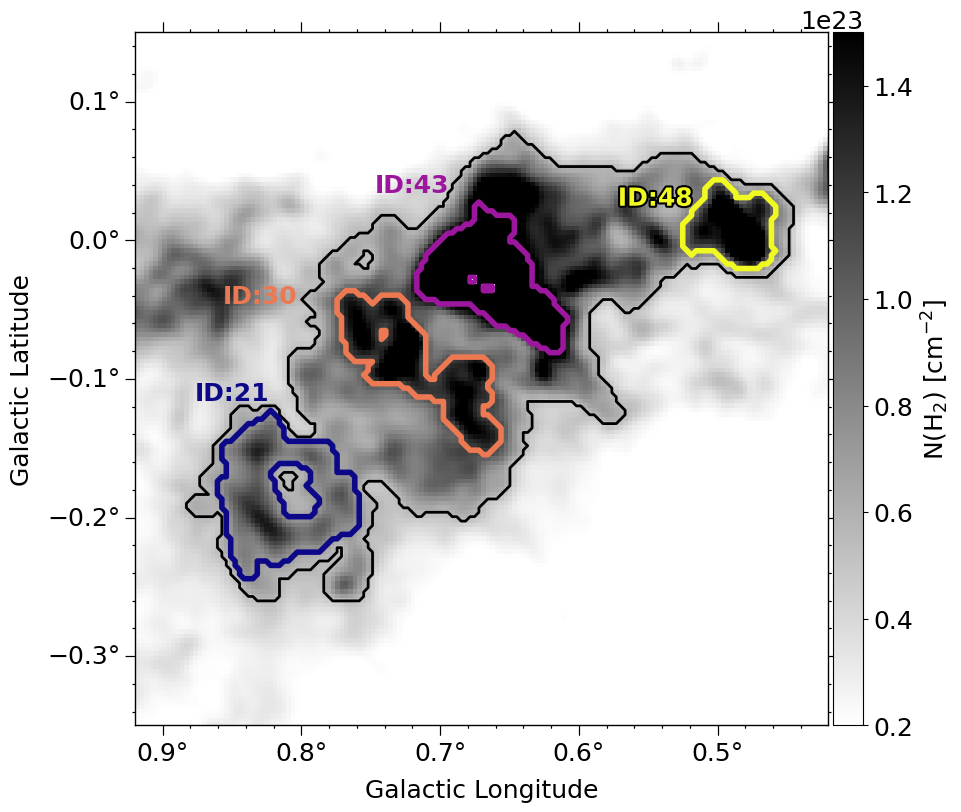

In [64]:
# Plot structures on column density image, save as .pdf file
# Sgr B2

%matplotlib inline
plt.rcParams.update({'font.size': 18}) #set fontsize

cmap = plt.get_cmap('plasma')
array = np.linspace(0,1,len(sts_sgrb2))
rgb_sgrb2 = cmap(array)

fig=aplpy.FITSFigure(path+'column_properunits_conv36_source_only.fits')
fig.recenter(0.67,-0.1, width=0.5, height=0.5)
fig.show_colorscale(cmap='Greys_r',vmin=2e+22,vmax=1.5e+23)
fig.add_colorbar()
fig.colorbar.set_width(0.3)
fig.colorbar.set_axis_label_text('N(H$_2$) [cm$^{-2}$]')
fig.set_theme('publication')
fig.tick_labels.set_xformat('ddd.d')
fig.tick_labels.set_yformat('ddd.d')

# Show outer "general" region selected as black contour
fig.show_contour(path+'sgrb2.fits', colors='black', levels=[0], linewidths=2)

i=0
for st in sts_sgrb2:
    fig.show_contour(pathsgrb2+'sgrb2_st'+str(st)+'.fits', colors=[rgb_sgrb2[i]],linewidths=4, levels=[0])
    i+=1

# Add labels for each structure - done by hand, bc seems easier??
# structure list: print(sts_sgrb2) = [21, 43, 30, 48]
fig.add_label(0.85, -0.11, 'ID:21', relative=False, color=rgb_sgrb2[0], weight='bold') #21
fig.add_label(0.72, 0.04, 'ID:43', relative=False, color=rgb_sgrb2[1], weight='bold') #43
fig.add_label(0.83, -0.04, 'ID:30', relative=False, color=rgb_sgrb2[2], weight='bold') #30
fig.add_label(0.545, 0.03, 'ID:48', relative=False, color=rgb_sgrb2[3], weight='bold', 
              path_effects=[path_effects.Stroke(linewidth=3, foreground='black'),path_effects.Normal()]) #48

plt.savefig(pathfigs+'sgrb2_regions_image.pdf',
            format='pdf', dpi=300, bbox_inches='tight')
plt.show()

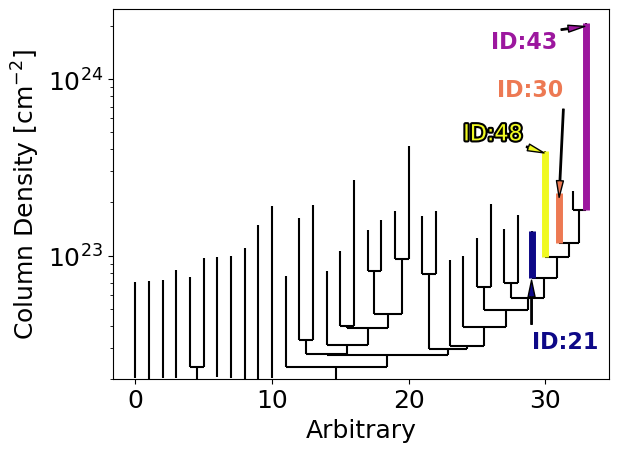

In [112]:
# Plot a dendrogram tree with highlights for each section
%matplotlib inline

# Initiate dendrogram plotter and plot parameters
p = d.plotter()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_ylim([2e22, 2.5e24])
ax.set_yscale('log')
plt.rcParams.update({'font.size': 16}) #set fontsize

# Plot the whole tree
p.plot_tree(ax, color='black')

# Sgr B2
i=0
for st in sts_sgrb2:
    p.plot_tree(ax, [st], color=[rgb_sgrb2[i]], lw=5)
    i+=1

ax.set_xlabel("Arbitrary")
ax.set_ylabel("Column Density [cm$^{-2}$]")

# structure list: print(sts_sgrb2) = [21, 43, 30, 48]
#21
ax.annotate('ID:21', xy=(29,7.5e22), xycoords='data', xytext=(29, 3e22),
            arrowprops=dict(facecolor=rgb_sgrb2[0], width=1, headwidth=5, shrink=0.05), 
            fontsize=16, fontweight='bold',color=rgb_sgrb2[0])
#43
ax.annotate('ID:43', xy=(33,2e24), xycoords='data', xytext=(26, 1.5e24),
            arrowprops=dict(facecolor=rgb_sgrb2[1], width=1, headwidth=5, shrink=0.05), 
            fontsize=16, fontweight='bold',color=rgb_sgrb2[1])
#30
ax.annotate('ID:30', xy=(31,2e23), xycoords='data', xytext=(26.5, 8e23),
            arrowprops=dict(facecolor=rgb_sgrb2[2], width=1, headwidth=5, shrink=0.05), 
            fontsize=16, fontweight='bold',color=rgb_sgrb2[2])

#48
ax.annotate('ID:48', xy=(30,3.8e23), xycoords='data', xytext=(24, 4.5e23),
            arrowprops=dict(facecolor=rgb_sgrb2[3], width=1, headwidth=5, shrink=0.05), 
            fontsize=16, color=rgb_sgrb2[3],
            path_effects=[path_effects.Stroke(linewidth=3, foreground='black'),path_effects.Normal()])

plt.savefig(pathfigs+'sgrb2_dendro_regions.pdf',
            format='pdf', dpi=300, bbox_inches='tight')

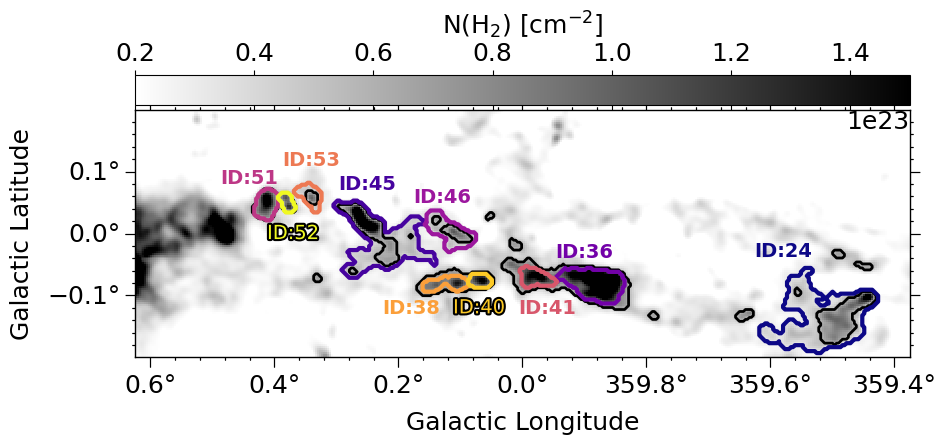

In [111]:
# Plot structures on column density image, save as .pdf file
# Inner 100pc
%matplotlib inline
plt.rcParams.update({'font.size': 18}) #set fontsize

cmap = plt.get_cmap('plasma')
array = np.linspace(0,1,len(sts_inner))
rgb_inner = cmap(array)

fig=aplpy.FITSFigure(path+'column_properunits_conv36_source_only.fits')
fig.recenter(0.0,0.0, width=1.25, height=0.4)
fig.show_colorscale(cmap='Greys_r',vmin=2e+22,vmax=1.5e+23)
fig.add_colorbar()
fig.colorbar.set_width(0.3)
fig.colorbar.set_location('top')
fig.set_theme('publication')
fig.colorbar.set_axis_label_text('N(H$_2$) [cm$^{-2}$]')
fig.tick_labels.set_xformat('ddd.d')
fig.tick_labels.set_yformat('ddd.d')

# Show outer "general" region selected as black contour
fig.show_contour(path+'r_lt_100pc.fits', colors='black', levels=[0], linewidths=2)
i=0
for st in sts_inner:
    fig.show_contour(pathinner+'inner_st'+str(st)+'.fits', colors=[rgb_inner[i]],linewidths=3, levels=[0])
    i+=1

# Add labels for each structure - done by hand, bc seems easier??
# structure list: print(sts_inner) = [24, 45, 36, 46, 51, 41, 53, 38, 40, 52]
fig.add_label(359.58, -0.028, 'ID:24', relative=False, color=rgb_inner[0], weight='bold', size=14) #24
fig.add_label(0.25, 0.08, 'ID:45', relative=False, color=rgb_inner[1], weight='bold', size=14) #45
fig.add_label(359.9, -0.03, 'ID:36', relative=False, color=rgb_inner[2], weight='bold', size=14) #36
fig.add_label(0.13, 0.06, 'ID:46', relative=False, color=rgb_inner[3], weight='bold', size=14) #46
fig.add_label(0.44, 0.09, 'ID:51', relative=False, color=rgb_inner[4], weight='bold', size=14) #51
fig.add_label(359.96, -0.12, 'ID:41', relative=False, color=rgb_inner[5], weight='bold', size=14) #41
fig.add_label(0.34, 0.12, 'ID:53', relative=False, color=rgb_inner[6], weight='bold', size=14) #53
fig.add_label(0.18, -0.12, 'ID:38', relative=False, color=rgb_inner[7], weight='bold', size=14) #38
fig.add_label(0.07, -0.12, 'ID:40', relative=False, color=rgb_inner[8],  size=14,
             path_effects=[path_effects.Stroke(linewidth=3, foreground='black'),path_effects.Normal()]) #40
fig.add_label(0.37, 0.0, 'ID:52', relative=False, color=rgb_inner[9],  size=14,
             path_effects=[path_effects.Stroke(linewidth=3, foreground='black'),path_effects.Normal()]) #52

plt.savefig(pathfigs+'inner100pc_regions_image.pdf',
            format='pdf', dpi=300, bbox_inches='tight')
plt.show()



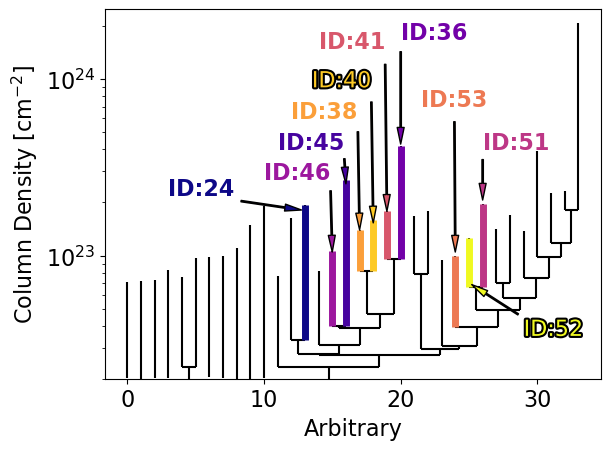

In [199]:
# Plot a dendrogram tree with highlights for each section
%matplotlib inline

# Initiate dendrogram plotter and plot parameters
p = d.plotter()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_ylim([2e22, 2.5e24])
ax.set_yscale('log')
plt.rcParams.update({'font.size': 16}) #set fontsize

# Plot the whole tree
p.plot_tree(ax, color='black')

# Inner 100 pc
i=0
for st in sts_inner:
    p.plot_tree(ax, [st], color=[rgb_inner[i]], lw=5)
    i+=1

ax.set_xlabel("Arbitrary")
ax.set_ylabel("Column Density [cm$^{-2}$]")

# structure list: print(sts_inner) = [24, 45, 36, 46, 51, 41, 53, 38, 40, 52]
ax.annotate('ID:24', xy=(13,1.8e23), xycoords='data', xytext=(3, 2.2e23),
            arrowprops=dict(facecolor=rgb_inner[0], width=1, headwidth=5, shrink=0.05), 
            fontsize=16, fontweight='bold',color=rgb_inner[0])
ax.annotate('ID:45', xy=(16,2.5e23), xycoords='data', xytext=(11, 4e23),
            arrowprops=dict(facecolor=rgb_inner[1], width=1, headwidth=5, shrink=0.05), 
            fontsize=16, fontweight='bold',color=rgb_inner[1])
ax.annotate('ID:36', xy=(20,4e23), xycoords='data', xytext=(20, 1.7e24),
            arrowprops=dict(facecolor=rgb_inner[2], width=1, headwidth=5, shrink=0.05), 
            fontsize=16, fontweight='bold',color=rgb_inner[2])
ax.annotate('ID:46', xy=(15,1e23), xycoords='data', xytext=(10, 2.7e23),
            arrowprops=dict(facecolor=rgb_inner[3], width=1, headwidth=5, shrink=0.05), 
            fontsize=16, fontweight='bold',color=rgb_inner[3])
ax.annotate('ID:51', xy=(26,2e23), xycoords='data', xytext=(26, 4e23),
            arrowprops=dict(facecolor=rgb_inner[4], width=1, headwidth=5, shrink=0.05), 
            fontsize=16, fontweight='bold',color=rgb_inner[4])
ax.annotate('ID:41', xy=(19,1.6e23), xycoords='data', xytext=(14, 1.5e24),
            arrowprops=dict(facecolor=rgb_inner[5], width=1, headwidth=5, shrink=0.05), 
            fontsize=16, fontweight='bold',color=rgb_inner[5])
ax.annotate('ID:53', xy=(24,9.5e22), xycoords='data', xytext=(21.5, 7e23),
            arrowprops=dict(facecolor=rgb_inner[6], width=1, headwidth=5, shrink=0.05), 
            fontsize=16, fontweight='bold',color=rgb_inner[6])
ax.annotate('ID:38', xy=(17,1.3e23), xycoords='data', xytext=(12, 6e23),
            arrowprops=dict(facecolor=rgb_inner[7], width=1, headwidth=5, shrink=0.05), 
            fontsize=16, fontweight='bold',color=rgb_inner[7])
ax.annotate('ID:40', xy=(18,1.4e23), xycoords='data', xytext=(13.5, 9e23),
            arrowprops=dict(facecolor=rgb_inner[8], width=1, headwidth=5, shrink=0.05), 
            fontsize=16, color=rgb_inner[8],
           path_effects=[path_effects.Stroke(linewidth=3, foreground='black'),path_effects.Normal()])
ax.annotate('ID:52', xy=(25,7e22), xycoords='data', xytext=(29, 3.5e22),
            arrowprops=dict(facecolor=rgb_inner[9], width=1, headwidth=5, shrink=0.05), 
            fontsize=16, color=rgb_inner[9],
            path_effects=[path_effects.Stroke(linewidth=3, foreground='black'),path_effects.Normal()])

plt.savefig(pathfigs+'inner100pc_dendro_regions.pdf',
            format='pdf', dpi=300, bbox_inches='tight')

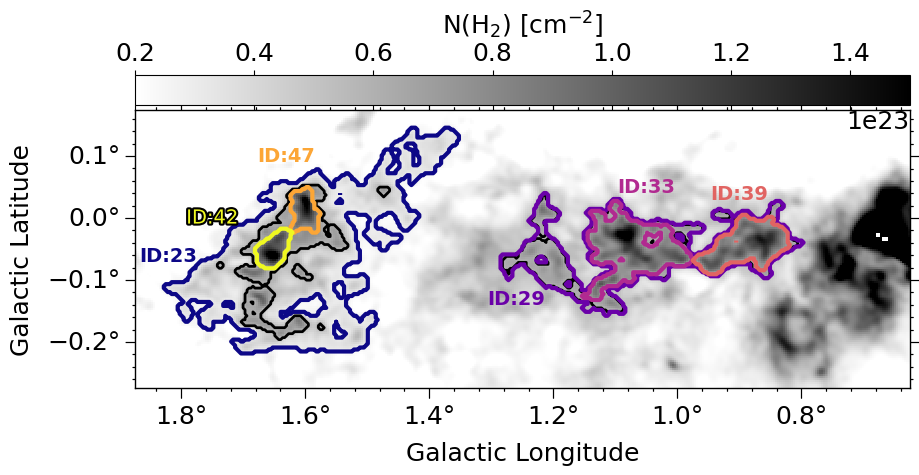

In [190]:
# Plot structures on column density image, save as .pdf file
# Outer100pc
%matplotlib inline
plt.rcParams.update({'font.size': 18}) #set fontsize

cmap = plt.get_cmap('plasma')
array = np.linspace(0,1,len(sts_outer))
rgb_outer = cmap(array)

fig=aplpy.FITSFigure(path+'column_properunits_conv36_source_only.fits')
fig.recenter(1.25,-0.05, width=1.25, height=0.45)
fig.show_colorscale(cmap='Greys_r',vmin=2e+22,vmax=1.5e+23)
fig.add_colorbar()
fig.colorbar.set_width(0.3)
fig.colorbar.set_location('top')
fig.set_theme('publication')
fig.colorbar.set_axis_label_text('N(H$_2$) [cm$^{-2}$]')
fig.tick_labels.set_xformat('ddd.d')
fig.tick_labels.set_yformat('ddd.d')

# Show outer "general" region selected as black contour
fig.show_contour(path+'r_gt_100pc.fits', colors='black', levels=[0], linewidths=2)

i=0
for st in sts_outer:
    fig.show_contour(pathouter+'outer_st'+str(st)+'.fits', colors=[rgb_outer[i]],linewidths=3, levels=[0])
    i+=1

# Add labels for each structure - done by hand, bc seems easier??
# structure list: print(sts_outer) = [23, 29, 33, 39, 47, 42]
fig.add_label(1.82, -0.06, 'ID:23', relative=False, color=rgb_outer[0], weight='bold', size=14) #23
fig.add_label(1.26, -0.13, 'ID:29', relative=False, color=rgb_outer[1], weight='bold', size=14) #29
fig.add_label(1.05, 0.05, 'ID:33', relative=False, color=rgb_outer[2], weight='bold', size=14) #33
fig.add_label(0.9, 0.04, 'ID:39', relative=False, color=rgb_outer[3], weight='bold', size=14) #39
fig.add_label(1.63, 0.1, 'ID:47', relative=False, color=rgb_outer[4], weight='bold', size=14) #47
fig.add_label(1.75, -0.0, 'ID:42', relative=False, color=rgb_outer[5], size=14,
             path_effects=[path_effects.Stroke(linewidth=3, foreground='black'),path_effects.Normal()]) #42

plt.savefig(pathfigs+'outer100pc_regions_image.pdf',
            format='pdf', dpi=300, bbox_inches='tight')
plt.show()

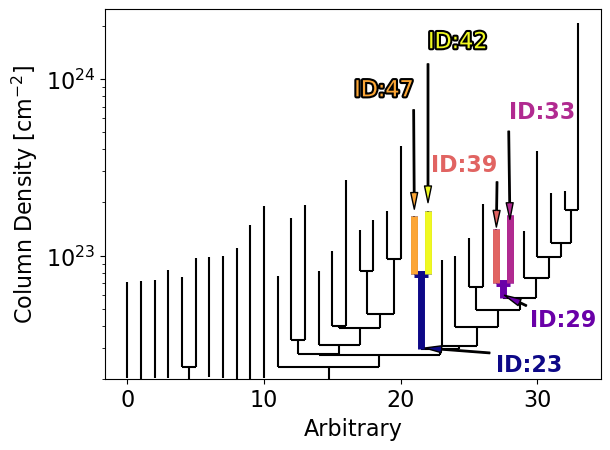

In [236]:
# Plot a dendrogram tree with highlights for each section
%matplotlib inline

# Initiate dendrogram plotter and plot parameters
p = d.plotter()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_ylim([2e22, 2.5e24])
ax.set_yscale('log')
plt.rcParams.update({'font.size': 16}) #set fontsize

# Plot the whole tree
p.plot_tree(ax, color='black')

# Outer 100 pc
i=0
for st in sts_outer:
    p.plot_tree(ax, [st], color=[rgb_outer[i]], lw=5)
    i+=1

ax.set_xlabel("Arbitrary")
ax.set_ylabel("Column Density [cm$^{-2}$]")

# structure list: print(sts_outer) = [23, 29, 33, 39, 47, 42]
ax.annotate('ID:23', xy=(21.5,3e22), xycoords='data', xytext=(27, 2.2e22),
            arrowprops=dict(facecolor=rgb_outer[0], width=1, headwidth=5, shrink=0.05), 
            fontsize=16, fontweight='bold',color=rgb_outer[0])
ax.annotate('ID:29', xy=(27.5,6e22), xycoords='data', xytext=(29.5, 4e22),
            arrowprops=dict(facecolor=rgb_outer[1], width=1, headwidth=5, shrink=0.05), 
            fontsize=16, fontweight='bold',color=rgb_outer[1])
ax.annotate('ID:33', xy=(28,1.5e23), xycoords='data', xytext=(27.9, 6e23),
            arrowprops=dict(facecolor=rgb_outer[2], width=1, headwidth=5, shrink=0.05), 
            fontsize=16, fontweight='bold',color=rgb_outer[2])
ax.annotate('ID:39', xy=(27,1.4e23), xycoords='data', xytext=(22.2, 3e23),
            arrowprops=dict(facecolor=rgb_outer[3], width=1, headwidth=5, shrink=0.05), 
            fontsize=16, fontweight='bold',color=rgb_outer[3])
ax.annotate('ID:47', xy=(21,1.7e23), xycoords='data', xytext=(16.6, 8e23),
            arrowprops=dict(facecolor=rgb_outer[4], width=1, headwidth=5, shrink=0.05), 
            fontsize=16, color=rgb_outer[4],
            path_effects=[path_effects.Stroke(linewidth=3, foreground='black'),path_effects.Normal()])
ax.annotate('ID:42', xy=(22,1.8e23), xycoords='data', xytext=(22, 1.5e24),
            arrowprops=dict(facecolor=rgb_outer[5], width=1, headwidth=5, shrink=0.05), 
            fontsize=16, color=rgb_outer[5],
            path_effects=[path_effects.Stroke(linewidth=3, foreground='black'),path_effects.Normal()])

plt.savefig(pathfigs+'outer100pc_dendro_regions.pdf',
            format='pdf', dpi=300, bbox_inches='tight')


In [13]:
# Conversation with AG on logarithmic bins and how we plot a log fit on top of them: 
# basically, the log-spaced bin widths are variable in linear space.  Say we have a range from 
# 1 to 10 with 3 bins.  In linear space, that's 1-4, 4-7, 7-10.  In log space, that's... 
# 1-2.15, 2.15-4.64, 4.64-10.  So the widths are 3,3,3 in the first case and (1.15, 2.48, 5.35) 
# in the second.  So when you're calculating the histogram, 
# it's integral(p(x), bin_start, bin_end) (or int(p(x) dx)).  
# For the linear case, no problem, that is going to look just like p(x).  
# But for the log case, that's no longer giving you the same result because 
# your integral looks like int(p(x) d log x) , where d log x is the bin width.

# int p(x) d log x = int p(x)/x dx
# (again dropping constants.... :grimacing: )


xmin progress: 87%

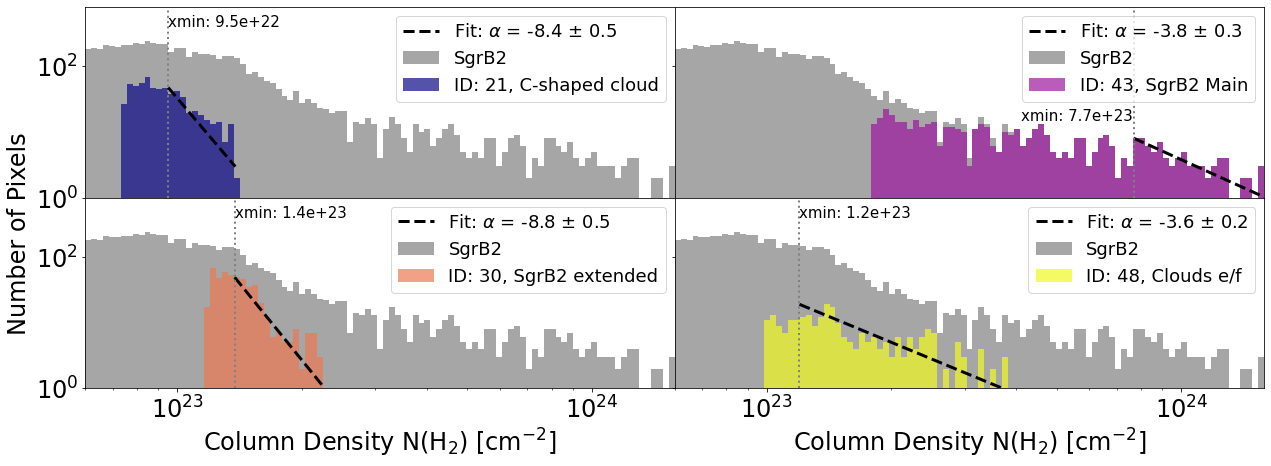

In [15]:
### Now with log fit!
# Plot joint figure with all PDFs, sample code from: 
# https://stackoverflow.com/questions/20174468/how-to-create-subplots-of-pictures-made-with-the-hist-function-in-matplotlib-p

### SgrB2 ###

fig,a = plt.subplots(2,2, sharex=True, sharey=True, figsize=(18, 7))
custom_xlim = (10**22.77815,10**24.2)
custom_ylim = (1,800)
plt.setp(a, xlim=custom_xlim, ylim=custom_ylim)
plt.style.use('default')
plt.rcParams.update({'font.size': 24}) #set fontsize

a = a.ravel()
i=1
for idx,ax in enumerate(a):
    bins = np.logspace(22.77815, 24.2,100)
    st = sts_sgrb2[idx]
    regnum = sgr['reg'+str(st)]
    z = regnum[regnum>6e22] #was 0
    reglabel = 'ID: '+str(st)+', '+names_sgrb2[idx]
    base= sgrb2
    baselabel= 'SgrB2'
    color= [rgb_sgrb2[idx]]
    ax.hist(base, bins, color='gray',alpha=0.7, log='True', label=baselabel)
    ax.set_xlabel('Column Density N(H$_2$) [cm$^{-2}$]')
    H, L, p = ax.hist(z, bins, color=color,alpha=0.7, log='True', label=reglabel)
    ax.set_xscale('log')
    
    powerlaw_fit = powerlaw.Fit(z, verbose=False)
    if len(z) > 50 and sum(z > powerlaw_fit.xmin) > 50:
        xpl = np.geomspace(powerlaw_fit.xmin,np.nanmax(z))
        ypl_nn = xpl**(1-powerlaw_fit.alpha) # plotting p(log(x)) not p(x)
#       norm = np.max(H)/np.max(ypl_nn) # replaced this with the following line, suggested by Adam
        norm = np.max(H[L[1:]>=powerlaw_fit.xmin])/np.max(ypl_nn)
        ypl = ypl_nn * norm
        ax.plot(xpl,  ypl, color='black', linewidth=3, linestyle='--',
            label=r'Fit: $\alpha$ = {:0.1f} $\pm$ {:0.1f}'.format(-1.*powerlaw_fit.alpha, powerlaw_fit.sigma))
        ax.plot(np.full(2, powerlaw_fit.xmin), custom_ylim, linewidth=2, linestyle=':', color='gray')
        if st==43: #special placement to avoid legend
            ax.text(4.1e23, 15, 'xmin: {:0.1e}'.format(powerlaw_fit.xmin), fontsize=15)
        else:
            ax.text(powerlaw_fit.xmin, 400, 'xmin: {:0.1e}'.format(powerlaw_fit.xmin), fontsize=15)
    
    ax.legend(loc='upper right', shadow=False, fontsize=18)
    
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
fig.text(0.01, 0.5, 'Number of Pixels', va='center', rotation='vertical')

plt.gcf().subplots_adjust(left=0.07) # make room for xy-axis

outfile = pathfigs+'sgrb2_pdfs_ALL_wfit.pdf'
plt.savefig(outfile, format='pdf', dpi=300)#, bbox_inches='tight')


<ipython-input-16-2b7e8bf2dc08>:32: RuntimeWarning: divide by zero encountered in double_scalars
  norm = np.max(H[L[1:]>=powerlaw_fit.xmin])/np.max(ypl_nn)
<ipython-input-16-2b7e8bf2dc08>:33: RuntimeWarning: invalid value encountered in multiply
  ypl = ypl_nn * norm


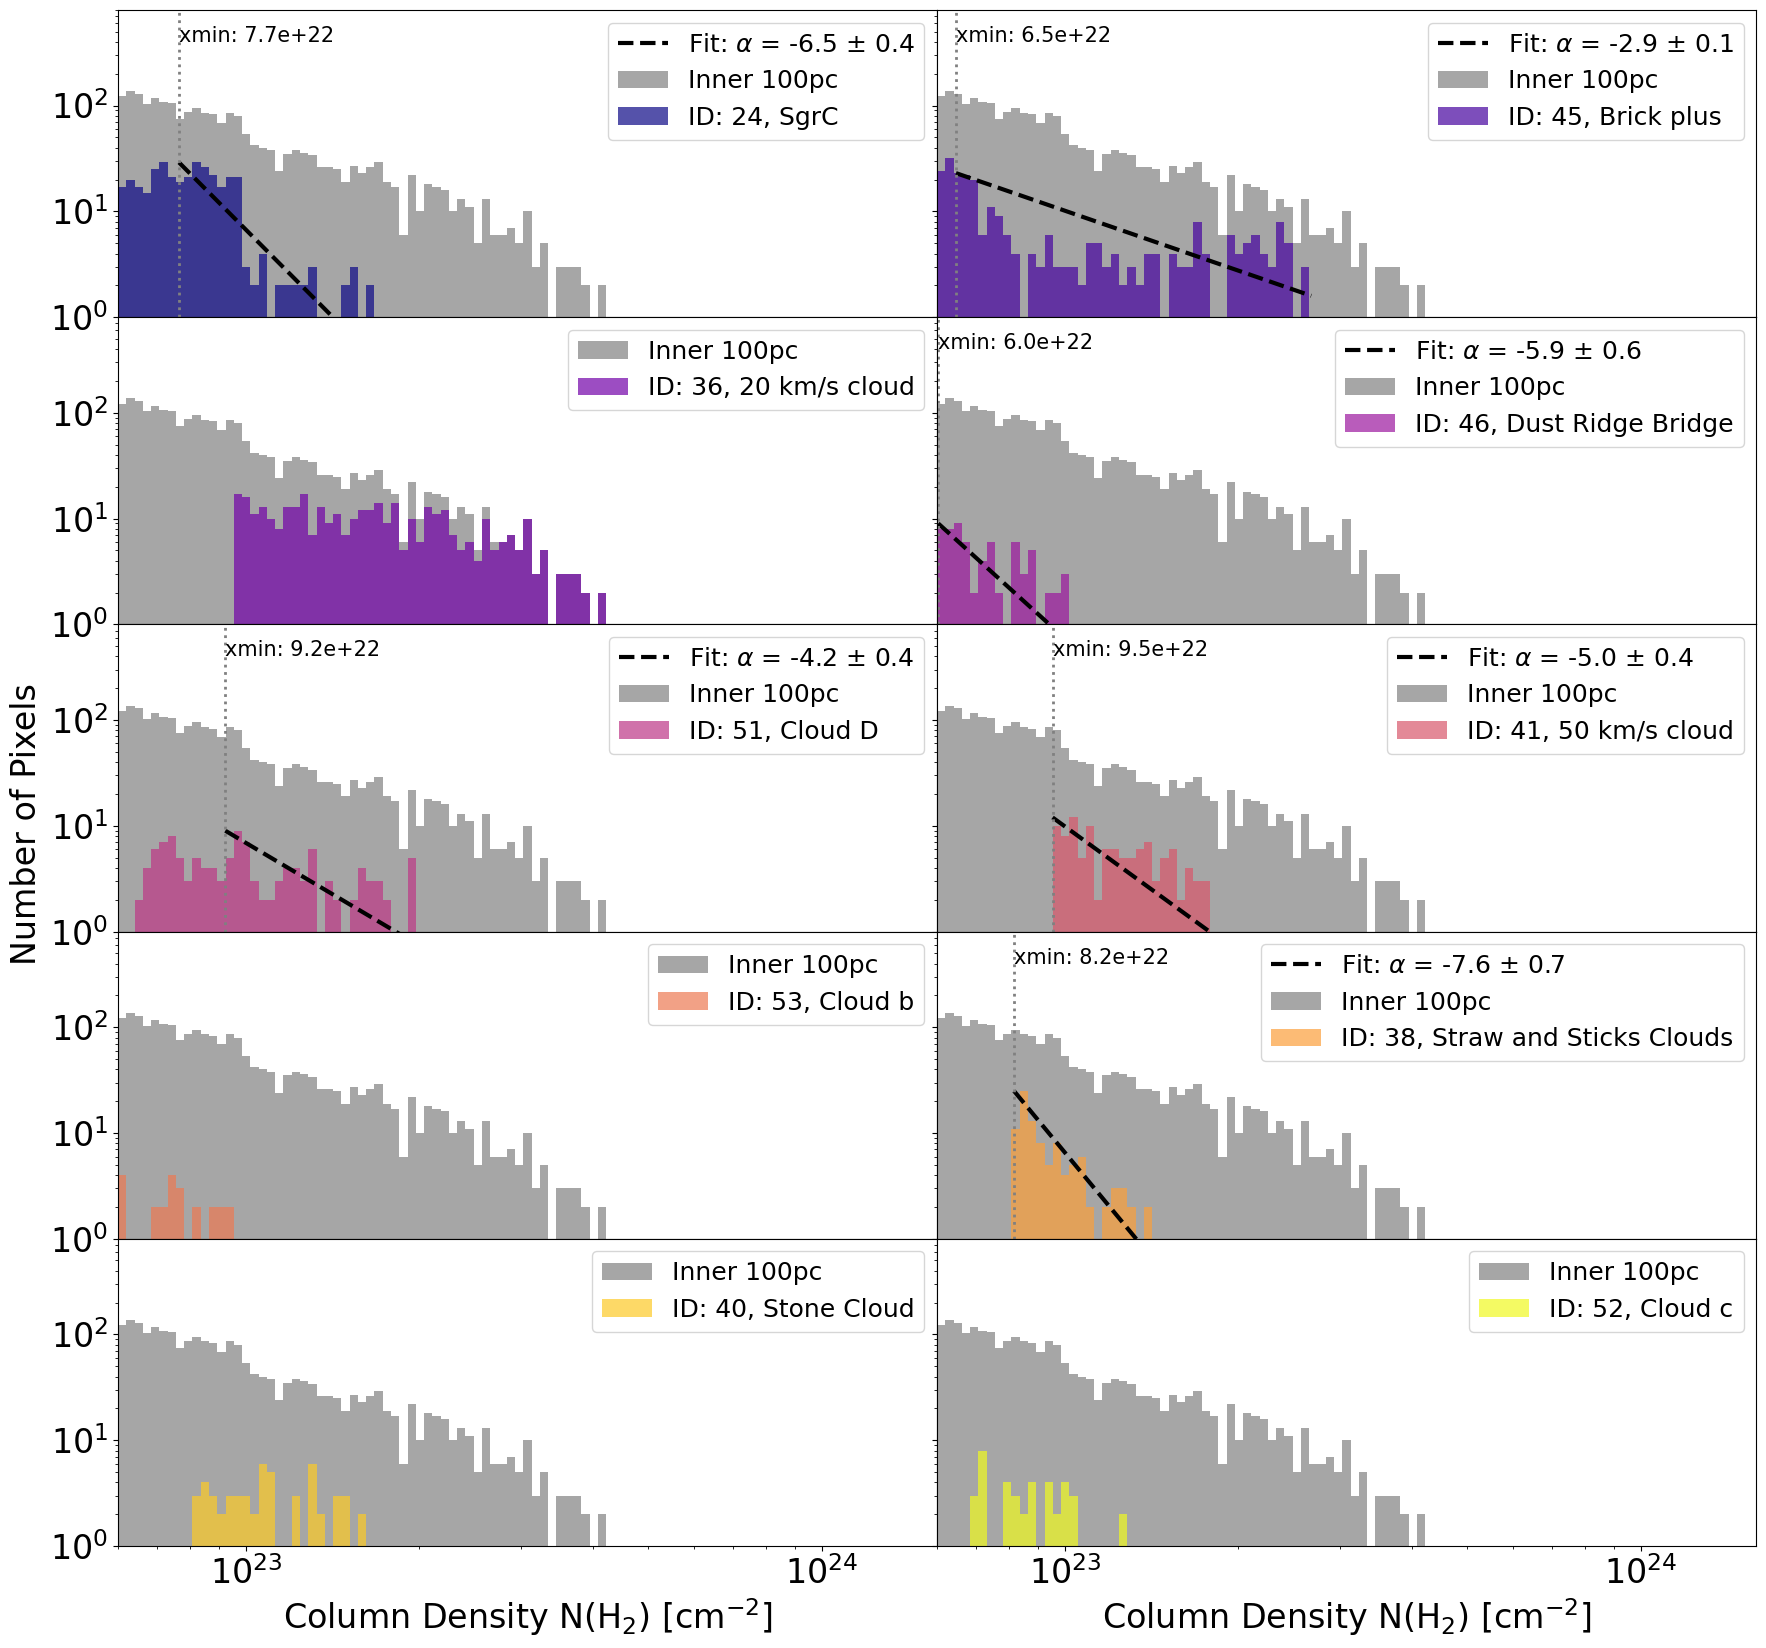

In [16]:
### Now with log fit!
# Plot joint figure with all PDFs, sample code from: 
# https://stackoverflow.com/questions/20174468/how-to-create-subplots-of-pictures-made-with-the-hist-function-in-matplotlib-p

### Inner 100pc ###

fig,a = plt.subplots(5,2, sharex=True, sharey=True, figsize=(18, 17))
custom_xlim = (10**22.77815,10**24.2)
custom_ylim = (1,800)
plt.setp(a, xlim=custom_xlim, ylim=custom_ylim)
plt.style.use('default')
plt.rcParams.update({'font.size': 24}) #set fon tsize


a = a.ravel()
for idx,ax in enumerate(a):
    bins = np.logspace(22.77815, 24.2,100)
    st = sts_inner[idx]
    regnum = inner['reg'+str(st)]
    z = regnum[regnum>6e22] #was 0
    reglabel = 'ID: '+str(st)+', '+names_inner100[idx]
    base= inner100
    baselabel= 'Inner 100pc'
    color= [rgb_inner[idx]]
    ax.hist(base, bins, color='gray',alpha=0.7, log='True', label=baselabel)
    ax.set_xlabel('Column Density N(H$_2$) [cm$^{-2}$]')
    H, L, p = ax.hist(z, bins, color=color,alpha=0.7, log='True', label=reglabel)
    ax.set_xscale('log')
    xpl = np.geomspace(powerlaw_fit.xmin,np.nanmax(z))
    ypl_nn = xpl**(1-powerlaw_fit.alpha) # plotting p(log(x)) not p(x)
#   norm = np.max(H)/np.max(ypl_nn) # replaced this with the following line, suggested by Adam
    norm = np.max(H[L[1:]>=powerlaw_fit.xmin])/np.max(ypl_nn)
    ypl = ypl_nn * norm

    powerlaw_fit = powerlaw.Fit(z, verbose=False)
    if len(z) > 50 and sum(z > powerlaw_fit.xmin) > 50:
        xpl = np.geomspace(powerlaw_fit.xmin,np.nanmax(z))
        ypl_nn = xpl**(1-powerlaw_fit.alpha) # plotting p(log(x)) not p(x)
        #norm = np.max(H)/np.max(ypl_nn) # replaced this with the following line, suggested by Adam
        norm = np.max(H[L[1:]>=powerlaw_fit.xmin])/np.max(ypl_nn)
        ypl = ypl_nn * norm
        ax.plot(xpl,  ypl, color='black', linewidth=3, linestyle='--',
            label=r'Fit: $\alpha$ = {:0.1f} $\pm$ {:0.1f}'.format(-1.0*powerlaw_fit.alpha, powerlaw_fit.sigma))
        ax.plot(np.full(2, powerlaw_fit.xmin), custom_ylim, linewidth=2, linestyle=':', color='gray')
        ax.text(powerlaw_fit.xmin, 400, 'xmin: {:0.1e}'.format(powerlaw_fit.xmin), fontsize=15)   
    # if st==46:
       #     ax.text(6.5e22, 400, 'xmin: {:0.1e}'.format(powerlaw_fit.xmin), fontsize=15)
       # else:
       #     ax.text(powerlaw_fit.xmin, 400, 'xmin: {:0.1e}'.format(powerlaw_fit.xmin), fontsize=15)
    
    ax.legend(loc='upper right', shadow=False, fontsize=18)
    
    
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
fig.text(0.01, 0.5, 'Number of Pixels', va='center', rotation='vertical')

plt.gcf().subplots_adjust(left=0.07) # make room for xy-axis

outfile = pathfigs+'Inner100pc_pdfs_ALL_wfit.pdf'
plt.savefig(outfile, format='pdf', dpi=300)#, bbox_inches='tight')


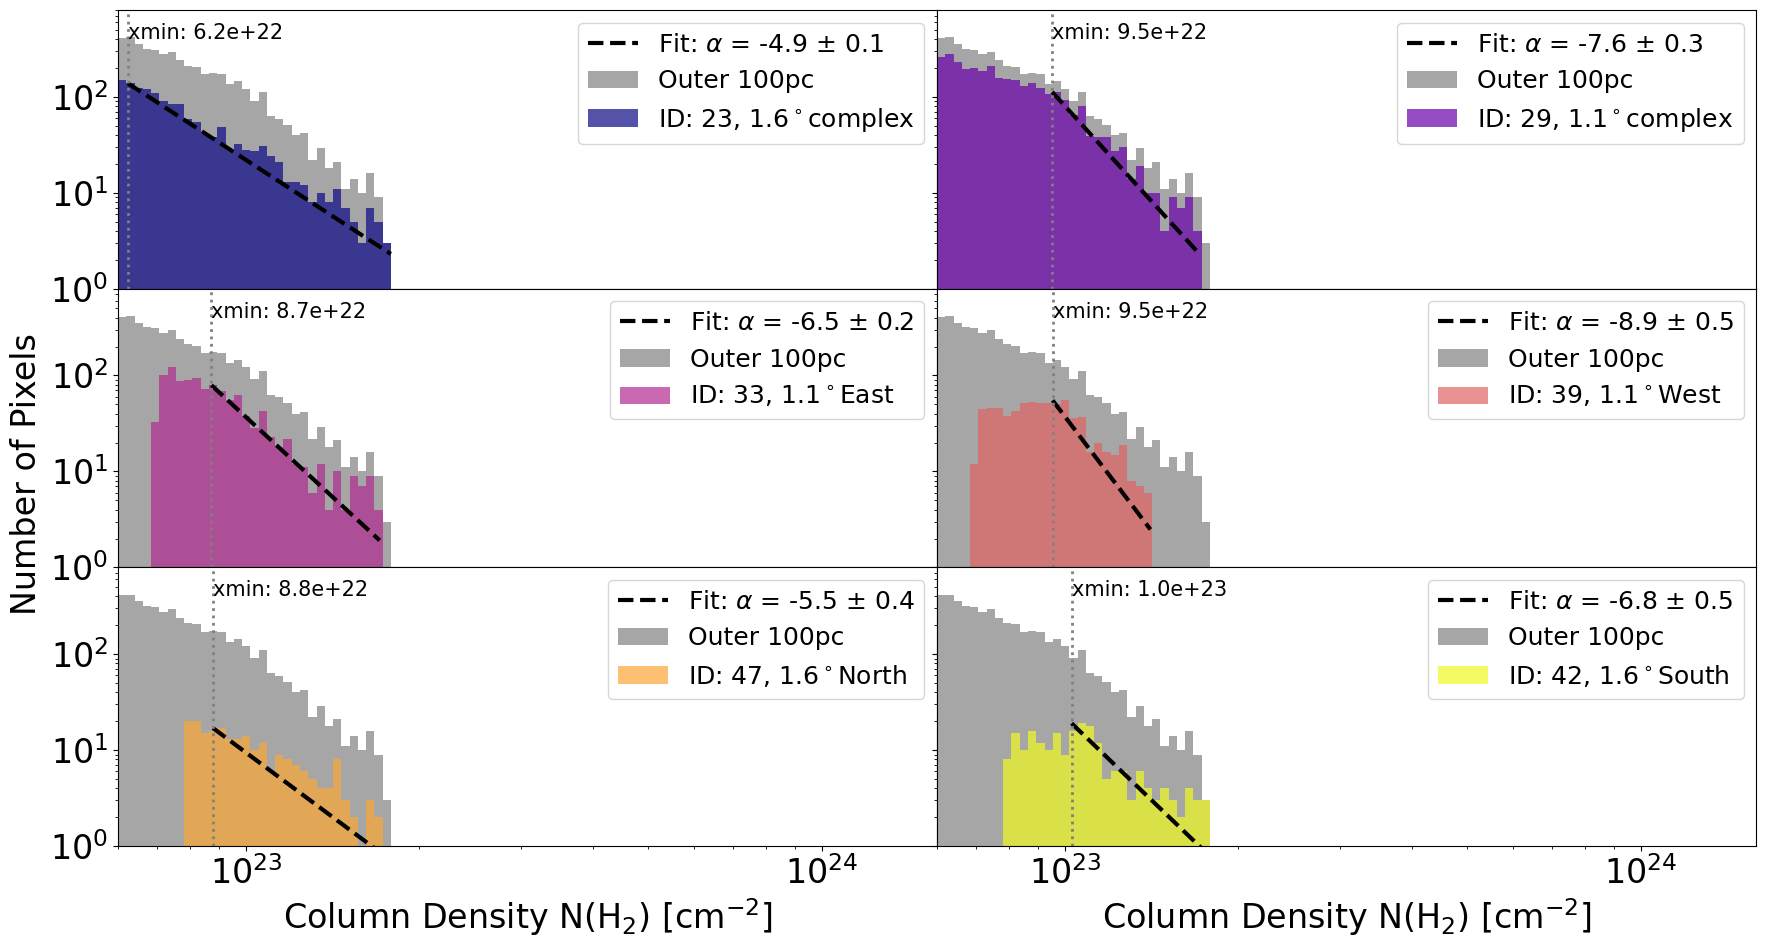

In [18]:
### Now with log fit!
# Plot joint figure with all PDFs, sample code from: 
# https://stackoverflow.com/questions/20174468/how-to-create-subplots-of-pictures-made-with-the-hist-function-in-matplotlib-p

### Outer 100pc ###

fig,a = plt.subplots(3,2, sharex=True, sharey=True, figsize=(18, 10))
custom_xlim = (10**22.77815,10**24.2)
custom_ylim = (1,800)
plt.setp(a, xlim=custom_xlim, ylim=custom_ylim)
plt.style.use('default')
plt.rcParams.update({'font.size': 24}) #set fon tsize


a = a.ravel()
for idx,ax in enumerate(a):
    bins = np.logspace(22.77815, 24.2,100)
    st = sts_outer[idx]
    regnum = outer['reg'+str(st)]
    z = regnum[regnum>6e22] # was 0
    reglabel = 'ID: '+str(st)+', '+names_outer100[idx]
    base= outer100
    baselabel= 'Outer 100pc'
    color= [rgb_outer[idx]]
    ax.hist(base, bins, color='gray',alpha=0.7, log='True', label=baselabel)
    ax.set_xlabel('Column Density N(H$_2$) [cm$^{-2}$]')
    H, L, p = ax.hist(z, bins, color=color,alpha=0.7, log='True', label=reglabel)#, density=True, stacked=True)
    ax.set_xscale('log')
 
    powerlaw_fit = powerlaw.Fit(z, verbose=False)
    if len(z) > 50 and sum(z > powerlaw_fit.xmin) > 50:
        xpl = np.geomspace(powerlaw_fit.xmin,np.nanmax(z))
        ypl_nn = xpl**(1-powerlaw_fit.alpha) # plotting p(log(x)) not p(x)
        #norm = np.max(H)/np.max(ypl_nn) # replaced this with the following line, suggested by Adam
        norm = np.max(H[L[1:]>=powerlaw_fit.xmin])/np.max(ypl_nn)
        ypl = ypl_nn * norm
        ax.plot(xpl,  ypl, color='black', linewidth=3, linestyle='--',
            label=r'Fit: $\alpha$ = {:0.1f} $\pm$ {:0.1f}'.format(-1.*powerlaw_fit.alpha, powerlaw_fit.sigma))
        ax.plot(np.full(2, powerlaw_fit.xmin), custom_ylim, linewidth=2, linestyle=':', color='gray')
        ax.text(powerlaw_fit.xmin, 400, 'xmin: {:0.1e}'.format(powerlaw_fit.xmin), fontsize=15)
    
    ax.legend(loc='upper right', shadow=False, fontsize=18)

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
fig.text(0.01, 0.5, 'Number of Pixels', va='center', rotation='vertical')

plt.gcf().subplots_adjust(left=0.07) # make room for xy-axis

outfile = pathfigs+'Outer100pc_pdfs_ALL_wfit.pdf'
plt.savefig(outfile, format='pdf', dpi=300)#, bbox_inches='tight')


In [17]:
### Now create power law fits for all of these regions and save to a LaTeX table
# had previously used plfit, but had problems with python upgrades and re-installation
# Adam indicates that: https://github.com/jeffalstott/powerlaw
# should give comparable results, is based on the same method and is better kept up-to-date.

# Previous fits were computed in the original "MLE_fitting_all.ipynb" 
# which was supposedly used to do all the MLE fits previously
# This was run on ALL dendrogram structures in add_powerlaws_to_table.py and appended to Table 4
# we decided just having a small dedicated table would be better for clear / clean interpretation
# now performed in this script.


In [19]:
# Perform power law fits to each region and save to a table 
# (table is unformatted and can be re-formatted by hand to include footnotes, captions, etc.)

st = []
name = []
xmin = []
alpha = []
sigma = []

#############
### SgrB2 ###
# Overall:
st.append(0)
name.append('SgrB2 Overall')
powerlaw_fit = powerlaw.Fit(sgrb2, verbose=False)
xmin.append(powerlaw_fit.xmin)
alpha.append(-1.*powerlaw_fit.alpha)
sigma.append(powerlaw_fit.sigma)
# Structures:
for i in range(len(sts_sgrb2)):
    st.append(sts_sgrb2[i])
    name.append(names_sgrb2[i])
    regnum = sgr['reg'+str(sts_sgrb2[i])]
    values=regnum[regnum > 6e22]
    powerlaw_fit = powerlaw.Fit(values, verbose=False)
    if len(values) > 50 and sum(values > powerlaw_fit.xmin) > 50:
        xmin.append(powerlaw_fit.xmin)
        alpha.append(-1.*powerlaw_fit.alpha)
        sigma.append(powerlaw_fit.sigma)
    else:
        print(len(values), sum(values > powerlaw_fit.xmin),'for', sts_sgrb2[i])
        xmin.append(0)
        alpha.append(0)
        sigma.append(0)
    
    
#print('# Greater than xmin: ', sum(arr > powerlaw_fit.xmin), 'for', sts_sgrb2[i])
    

#####################
### Inner 100 pc ###
# Overall:
st.append(0)
name.append('Inner 100 pc Overall')
powerlaw_fit = powerlaw.Fit(inner100, verbose=False)
xmin.append(powerlaw_fit.xmin)
alpha.append(-1.0*powerlaw_fit.alpha)
sigma.append(powerlaw_fit.sigma)
# Structures:
for i in range(len(sts_inner)):
    st.append(sts_inner[i])
    name.append(names_inner100[i])
    regnum = inner['reg'+str(sts_inner[i])]
    values=regnum[regnum > 6e22]
    powerlaw_fit = powerlaw.Fit(values, verbose=False)
    if len(values) > 50 and sum(values > powerlaw_fit.xmin) > 50:
        xmin.append(powerlaw_fit.xmin)
        alpha.append(-1.0*powerlaw_fit.alpha)
        sigma.append(powerlaw_fit.sigma)
    else:
        print(len(values), sum(values > powerlaw_fit.xmin),'for', sts_inner[i])
        xmin.append(0)
        alpha.append(0)
        sigma.append(0)    

    
####################
### Outer 100 pc ###
# Overall:
st.append(0)
name.append('Outer 100 pc Overall')
powerlaw_fit = powerlaw.Fit(outer100, verbose=False)
xmin.append(powerlaw_fit.xmin)
alpha.append(-1.0*powerlaw_fit.alpha)
sigma.append(powerlaw_fit.sigma)
# Structures:
for i in range(len(sts_outer)):
    st.append(sts_outer[i])
    name.append(names_outer100[i])
    regnum = outer['reg'+str(sts_outer[i])]
    values=regnum[regnum > 6e22]
    powerlaw_fit = powerlaw.Fit(values, verbose=False)
    if len(values) > 50 and sum(values > powerlaw_fit.xmin) > 50:
        xmin.append(powerlaw_fit.xmin)
        alpha.append(-1.0*powerlaw_fit.alpha)
        sigma.append(powerlaw_fit.sigma)
    else:
        print(len(values), sum(values > powerlaw_fit.xmin),'for', sts_outer[i])
        xmin.append(0)
        alpha.append(0)
        sigma.append(0)        


    
print(st, name, xmin, alpha, sigma)   
    
t = Table([st, name, xmin, alpha, sigma], 
          names=('Structure ID', 'Name', 'x$_{min}$ [cm$^{-2}$]',
                 'alpha', 'error'))#, meta={'name':'test'})

t['x$_{min}$ [cm$^{-2}$]'].info.format = '0.1e'
t['alpha'].info.format = '0.1f'
t['error'].info.format = '0.1f'


t.write(path+'power_law_fits_preformatting.tex', format='latex', overwrite=True)
# Can't figure out how to make super fancy in python 
#(e.g. $\alpha$ doesn't work and i don't really want to figure out why, nevermind trying to format the uncertainties!)
# so output this table, then HAND format to 'power_law_fits.tex' which goes into the paper. idk.

# Perry had some suggested sample code that may be useful if I re-do this again:
#print('\\begin{tabular}{llllll}')
#print('\hline\hline')
#print('Leaf ID & Mass Unc. & N$_{\\rm SMA}$ unc. & n unc. & $\\rho$ unc. & t$_{\\rm ff}$ unc. \\\\')
#print(' & (M$_\odot)$ & (cm$^{-2})$ & (cm$^{-3})$ & (g cm$^{-3})$ (yr) \\\\')              
#print('\hline')

#for i in np.arange(0,20):
#    print('%s & %1.2e & %1.2e& %1.2e & %1.2e & %1.2e \\\\' %\
#         (catalog['leaf_ID'][i],catalog['mass_unc'][i],catalog['N_unc'][i],catalog['n_unc'][i],catalog['rho_unc'][i],catalog['tff_unc'][i]))
#print('... & ... & ... & ... & ... & ... \\\\')            
#print('\hline\hline')
#print('\end{tabular}')


/Users/battersby/anaconda3/lib/python3.8/site-packages/powerlaw.py:102: RuntimeWarning: invalid value encountered in greater
  self.data = self.data[self.data>0]


381 41 for 36: 99%
26 4 for 53ss: 96%
58 39 for 40s: 98%
46 14 for 52s: 97%
[0, 21, 43, 30, 48, 0, 24, 45, 36, 46, 51, 41, 53, 38, 40, 52, 0, 23, 29, 33, 39, 47, 42] ['SgrB2 Overall', 'C-shaped cloud', 'SgrB2 Main', 'SgrB2 extended', 'Clouds e/f', 'Inner 100 pc Overall', 'SgrC', 'Brick plus', '20 km/s cloud', 'Dust Ridge Bridge', 'Cloud D', '50 km/s cloud', 'Cloud b', 'Straw and Sticks Clouds', 'Stone Cloud', 'Cloud c', 'Outer 100 pc Overall', '1.6$^\\circ$complex', '1.1$^\\circ$complex', '1.1$^\\circ$East', '1.1$^\\circ$West', '1.6$^\\circ$North', '1.6$^\\circ$South'] [1.7135776846659466e+23, 9.526906545260218e+22, 7.669504064622388e+23, 1.3775733938830663e+23, 1.1999779958173754e+23, 7.183707528217374e+22, 7.657384878025134e+22, 6.473233161802287e+22, 0, 6.030005099435141e+22, 9.214020762588504e+22, 9.523480206663714e+22, 0, 8.162813956285745e+22, 0, 0, 1.009680014858701e+23, 6.23917253232855e+22, 9.507681579170899e+22, 8.717056650187499e+22, 9.523736911842475e+22, 8.768579631364468e

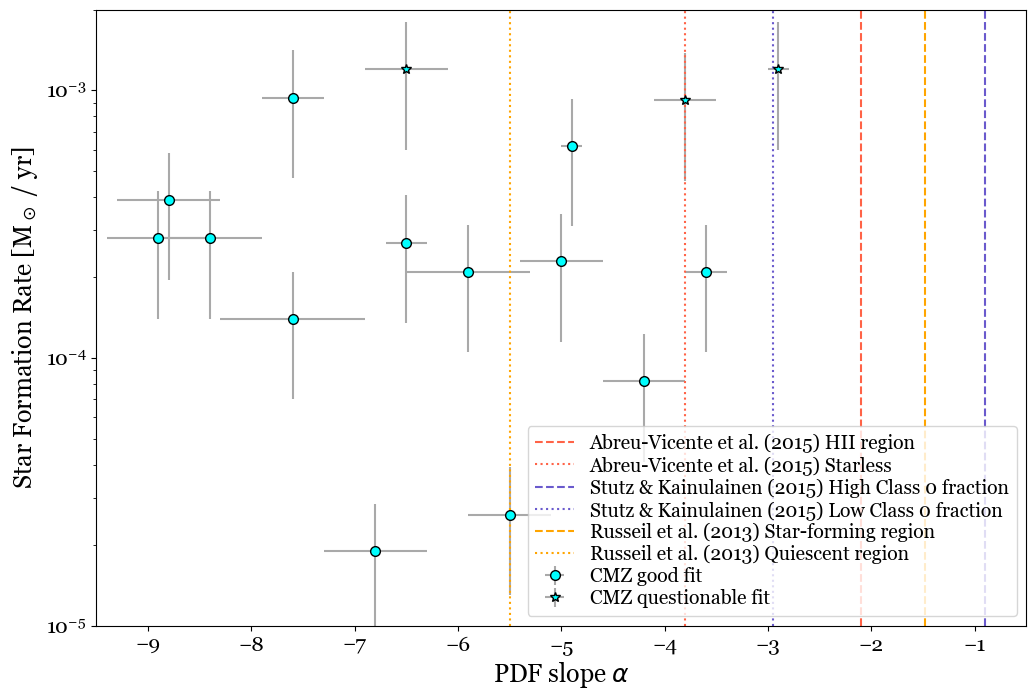

In [71]:
## Added September 2022 to compare power-law slopes with SFRs
#print(t['alpha'])
# moved to separate notebook: sfr_vs_alpha_plot.ipynb
# for simplicity!!!
SFRs = np.array([2.8E-04, 3.9E-04, 9.2E-04, 2.1E-04,
      1.2E-03, 1.2E-03, 2.1E-04, 8.2E-05, 2.3E-04, 1.4E-04,
      6.2E-04, 9.4E-04, 2.7E-04, 2.8E-04, 2.6E-05, 1.9E-05])
alphas = np.array([-8.4, -8.8, -3.8, -3.6,
                  -6.5, -2.9, -5.9, -4.2, -5.0, -7.6,
                  -4.9, -7.6, -6.5, -8.9, -5.5, -6.8])

# separate out regular from questionable
SFRs_good = np.array([2.8E-04, 3.9E-04, 2.1E-04,
      2.1E-04, 8.2E-05, 2.3E-04, 1.4E-04,
      6.2E-04, 9.4E-04, 2.7E-04, 2.8E-04, 2.6E-05, 1.9E-05])
alphas_good = np.array([-8.4, -8.8, -3.6,
                  -5.9, -4.2, -5.0, -7.6,
                  -4.9, -7.6, -6.5, -8.9, -5.5, -6.8])
alpha_err_good = np.array([0.5, 0.5, 0.2,
                          0.6, 0.4, 0.4, 0.7,
                          0.1, 0.3, 0.2, 0.5, 0.4, 0.5])

SFRs_maybe = np.array([9.2E-04,1.2E-03, 1.2E-03])
alphas_maybe = np.array([-3.8,-6.5, -2.9])
alpha_err_maybe = np.array([0.3, 0.4, 0.1])


plt.figure(figsize=(12,8))
#plt.plot(alphas_good,SFRs_good,ls='',marker='o',color='cyan',markersize='7',markeredgecolor='k', label='CMZ good')
#plt.plot(alphas_maybe,SFRs_maybe,ls='',marker='*',color='cyan',markersize='7',markeredgecolor='k', label='CMZ moderate')

plt.errorbar(alphas_good,SFRs_good, yerr=SFRs_good*0.5, xerr=alpha_err_good, ls='',marker='o',color='cyan',
             ecolor='darkgray',markersize='7',markeredgecolor='k', label='CMZ good fit')
plt.errorbar(alphas_maybe,SFRs_maybe,yerr=SFRs_maybe*0.5, xerr=alpha_err_maybe,ls='',marker='*',color='cyan',
             ecolor='darkgray',markersize='7',markeredgecolor='k', label='CMZ questionable fit')

ymin = 1e-5
ymax = 2e-3
plt.ylim(ymin, ymax)
plt.yscale('log')
plt.xlim(-9.5, -0.5)
plt.xlabel(r'PDF slope $\alpha$', **{'fontname':'Georgia'},fontsize=18)
plt.ylabel(r'Star Formation Rate [M$_\odot$ / yr]', **{'fontname':'Georgia'},fontsize=18)

#Abreu-Vicente 2015 averages
plt.plot([-2.1,-2.1], [ymin, ymax], ls='--', color='tomato', label='Abreu-Vicente et al. (2015) HII region')
plt.plot([-3.8,-3.8], [ymin, ymax], ls=':', color='tomato', label='Abreu-Vicente et al. (2015) Starless')

#Stutz & Kainulainen 2015 averages
plt.plot([-0.9,-0.9], [ymin, ymax], ls='--', color='slateblue', label='Stutz & Kainulainen (2015) High Class 0 fraction')
plt.plot([-2.95, -2.95], [ymin, ymax], ls=':', color='slateblue', label='Stutz & Kainulainen (2015) Low Class 0 fraction')

#Russeil et al. 2013 averages
plt.plot([-1.48, -1.48], [ymin, ymax], ls='--', color='orange', label='Russeil et al. (2013) Star-forming region')
plt.plot([-5.5, -5.5], [ymin, ymax], ls=':', color='orange', label='Russeil et al. (2013) Quiescent region')

plt.legend(loc='lower right', numpoints=1, ncol=1, fontsize=14, labelspacing=.16)

outfile = pathfigs+'SFR_vs_PDFslope.pdf'
plt.savefig(outfile, format='pdf', dpi=300)#, bbox_inches='tight')


<ipython-input-95-791a90a0024d>:7: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.setp(a, xlim=custom_xlim, ylim=custom_ylim)


Alpha parameter for this fit is:  7.599703679379831


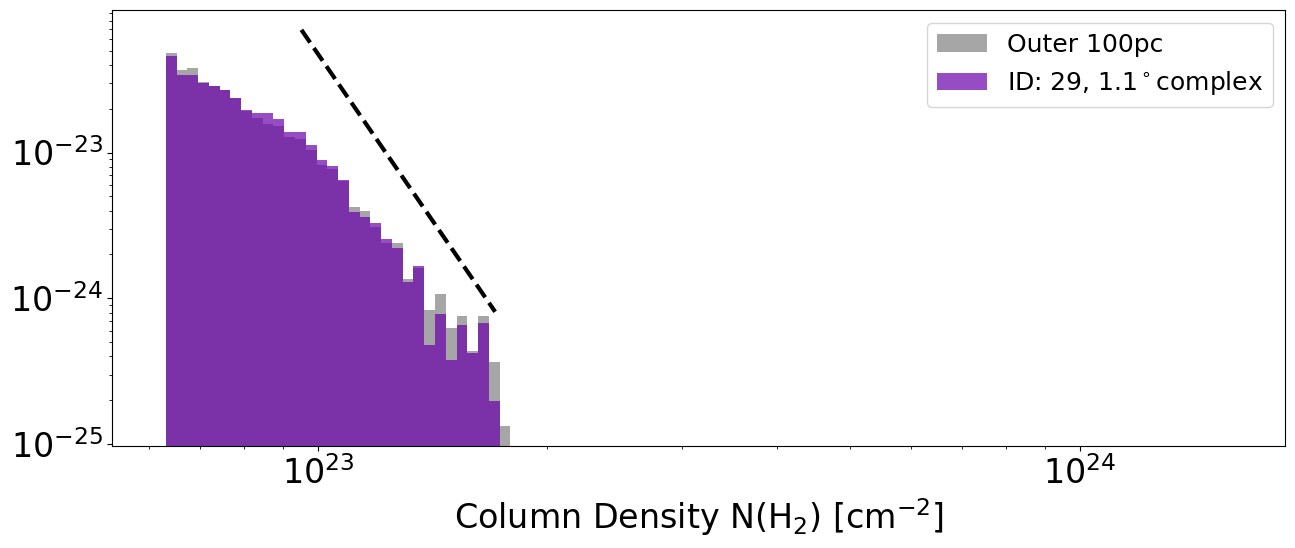

In [95]:
# testing various other histogram / overplotting
#NORMALIZED, WORKS BUT NOT PRETTY LIKE I WANT IT

histogram = plt.figure(1,figsize=(13,6))
ax = histogram.gca()
custom_xlim = (10**22.77815,10**24.2)
custom_ylim = (0,1)
plt.setp(a, xlim=custom_xlim, ylim=custom_ylim)
plt.style.use('default')
plt.rcParams.update({'font.size': 24}) #set fon tsize
### THIS WORKS - NORMALIZED DATA TO TOTAL OF ONE using: ", density=True, stacked=True"
# WOULD PREFER TO JUST SCALE THE FIT ... HOW DO I DO THIS???

### CARA - here!


idx=1
bins = np.logspace(22.77815, 24.2,100)
st = sts_outer[idx]
regnum = outer['reg'+str(st)]
z = regnum[regnum > 6e22]
powerlaw_fit = powerlaw.Fit(z, verbose=False)
print('Alpha parameter for this fit is: ', -1.*powerlaw_fit.alpha)
reglabel = 'ID: '+str(st)+', '+names_outer100[idx]
base= outer100
baselabel= 'Outer 100pc'
color= [rgb_outer[idx]]
ax.hist(base, bins, color='gray',alpha=0.7, log='True', label=baselabel, density=True, stacked=True)
ax.set_xlabel('Column Density N(H$_2$) [cm$^{-2}$]')
ax.hist(z, bins, color=color,alpha=0.7, log='True', label=reglabel, density=True, stacked=True)
ax.set_xscale('log')
ax.legend(loc='upper right', shadow=False, fontsize=18)
powerlaw_fit.power_law.plot_pdf(color='black', linewidth=3, linestyle='--', ax=ax)
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
fig.text(0.01, 0.5, 'Number of Pixels', va='center', rotation='vertical')

plt.gcf().subplots_adjust(left=0.07) # make room for xy-axis

<ipython-input-81-58a059bed6d2>:7: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.setp(a, xlim=custom_xlim, ylim=custom_ylim)


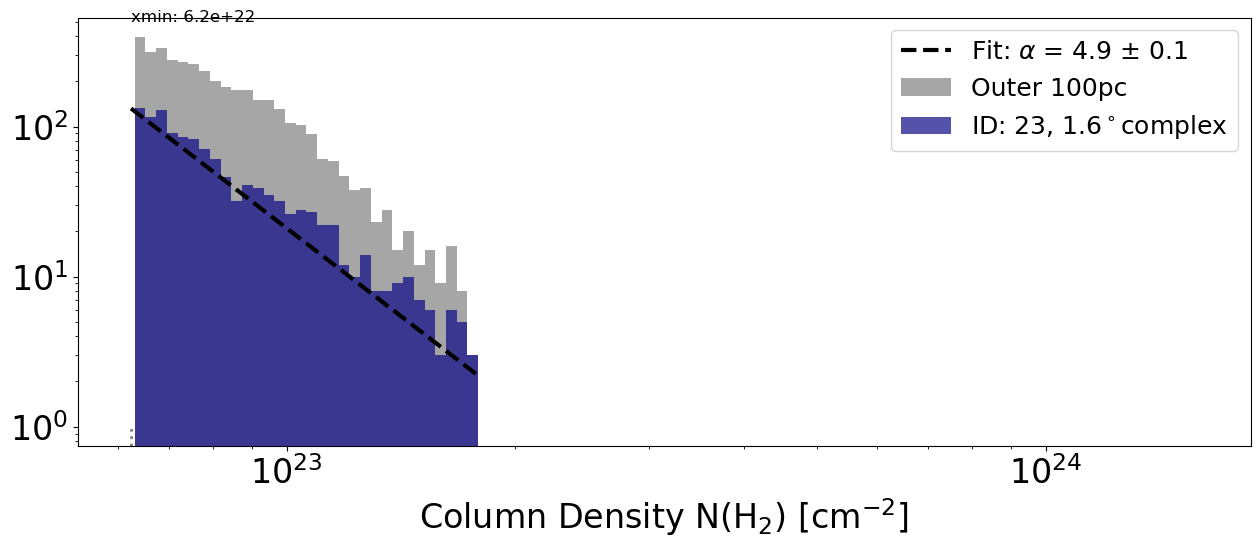

In [81]:
## ATTEMPTING NON-NORMALIZED

histogram = plt.figure(1,figsize=(13,6))
ax = histogram.gca()
custom_xlim = (10**22.77815,10**24.2)
custom_ylim = (0,1)
plt.setp(a, xlim=custom_xlim, ylim=custom_ylim)
plt.style.use('default')
plt.rcParams.update({'font.size': 24}) #set fon tsize
### THIS WORKS - NORMALIZED DATA TO TOTAL OF ONE using: ", density=True, stacked=True"
# WOULD PREFER TO JUST SCALE THE FIT ... HOW DO I DO THIS???

### CARA - here!


idx=0
bins = np.logspace(22.77815, 24.2,100)
st = sts_outer[idx]
regnum = outer['reg'+str(st)]
#powerlaw_fit = powerlaw.Fit(regnum, verbose=False)
reglabel = 'ID: '+str(st)+', '+names_outer100[idx]
base= outer100
baselabel= 'Outer 100pc'
color= [rgb_outer[idx]]
ax.hist(base, bins, color='gray',alpha=0.7, log='True', label=baselabel)#, density=True, stacked=True)
ax.set_xlabel('Column Density N(H$_2$) [cm$^{-2}$]')

z = regnum[regnum>0]
H, L, p = ax.hist(z, bins, color=color,alpha=0.7, log='True', label=reglabel)#, density=True, stacked=True)
ax.set_xscale('log')

# Powerlaw from fit for plotting
#powerlaw_fit.power_law.plot_pdf(color='black', linewidth=3, linestyle='--', ax=ax)
#nel=100
xpl = np.geomspace(powerlaw_fit.xmin,np.nanmax(z))#, nel)

#ypl_nn = xpl**(-1.*powerlaw_fit.alpha)  #NOT PLOTTING p(x), but p(logx)
#ypl_nn = np.log10(xpl)**(-1.*powerlaw_fit.alpha)

# This equation seems to work, maybe it means that: 
# the y-axis is int(p(x) dx) = x^(1-alpha)
ypl_nn = xpl**(1-powerlaw_fit.alpha) # magic formula from Adam, can't reproduce. 


#ypl_nn = L**(-1.0*powerlaw_fit.alpha)

#pl.loglog([x for a,b in zip(L[:-1],L[1:]) for x in (a,b)], np.repeat(H,2), drawstyle='steps-mid')
#C = (alpha-1) / z.min()**(1-alpha)
#pl.loglog(np.geomspace(z.min(), z.max()), np.geomspace(z.min(), z.max())**-alpha * H[0] / z.min()**-alpha)


#ypl_nn = bins**(-1.*powerlaw_fit.alpha)
#norm = np.sum(H) / np.sum(ypl_nn)
norm = np.max(H)/np.max(ypl_nn)
ypl = ypl_nn * norm

#ypl = ypl[L < z.max()]
#ll = L[L < z.max()]



ax.plot(xpl,  ypl, color='black', linewidth=3, linestyle='--',
        label=r'Fit: p = {:0.1f} $\pm$ {:0.1f}'.format(powerlaw_fit.alpha, powerlaw_fit.sigma))
#ax.plot(xpl,  ypl, color='black', linewidth=3, linestyle='--', label='Power law fit $\alpha$:{0.1f}'.format(powerlaw_fit.alpha))
ax.plot(np.full(2, powerlaw_fit.xmin), custom_ylim, linewidth=2, linestyle=':', color='gray')
ax.text(powerlaw_fit.xmin, 500, 'xmin: {:0.1e}'.format(powerlaw_fit.xmin), fontsize=12)

ax.legend(loc='upper right', shadow=False, fontsize=18)


plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
fig.text(0.01, 0.5, 'Number of Pixels', va='center', rotation='vertical')

plt.gcf().subplots_adjust(left=0.07) # make room for xy-axis

In [ ]:
### Previous code, saved in case it might be useful sometime.

In [46]:
# Plot histograms of all the regions
#THIS WORKS FINE - makes a separate .pdf figure file for EACH structure - see code above as
# attempt to combine each region into one joint PDF file
#%matplotlib inline

def plot_histograms(regnum, reglabel, base, baselabel, color, outfile):
    plt.style.use('default')
    plt.rcParams.update({'font.size': 24}) #set fontsize

    histogram = plt.figure(1,figsize=(13,6))
    ax = histogram.gca()
    plt.ylabel('Number of Pixels',)
    plt.xlabel('Column Density N(H$_2$) [cm$^{-2}$]',)

    bins = np.logspace(22.77815, 24.2,100)
    plt.hist(base, bins, color='gray',alpha=0.7, log='True', label=baselabel)
    plt.hist(regnum, bins, color=color,alpha=0.7, log='True', label=reglabel)
    plt.gca().set_xscale("log")
    ax.set_xlim(10**22.77815,10**24.2)
    ax.set_ylim(1,1000)
    plt.gcf().subplots_adjust(bottom=0.2) # make room for x-axis

    legend = plt.legend(loc='upper right', shadow=False, fontsize=24)#'x-large')
    plt.savefig(outfile, format='pdf', dpi=300)#, bbox_inches='tight')
    plt.clf()

# SgrB2
i=0
#rev_stssgrb2=list(reversed(sts_sgrb2))
for st in sts_sgrb2:
    plot_histograms(sgr['reg'+str(st)],'ID: '+str(st)+', '+names_sgrb2[i], sgrb2,'SgrB2',
                    [rgb_sgrb2[i]], pathfigs+'sgrb2_pdfs_st'+str(st)+'.pdf')
    i+=1

# Inner 100 pc
i=0
#for st in sts_inner:
#rev_stsinner=list(reversed(sts_inner))
for st in sts_inner:
    plot_histograms(inner['reg'+str(st)],'ID: '+str(st)+', '+names_inner100[i], inner100,'Inner 100pc',
                    [rgb_inner[i]], pathfigs+'inner100_pdfs_st'+str(st)+'.pdf')
    i+=1


# Outer 100 pc
i=0
#for st in sts_outer:
#rev_stsouter=list(reversed(sts_outer))
for st in sts_outer:
    plot_histograms(outer['reg'+str(st)],'ID: '+str(st)+', '+names_outer100[i], outer100,'Outer 100pc', 
                    [rgb_outer[i]], pathfigs+'outer100_pdfs_st'+str(st)+'.pdf')
    i+=1


<Figure size 1300x600 with 0 Axes>

In [240]:
### Made the screenshot showing pixel values for each fit - getting rid of for now...


st = []
name = []
xmin = []
alpha = []
sigma = []

#############
### SgrB2 ###
# Overall:
st.append(0)
name.append('SgrB2 Overall')
powerlaw_fit = powerlaw.Fit(sgrb2, verbose=False)
xmin.append(powerlaw_fit.xmin)
alpha.append(-1.0*powerlaw_fit.alpha)
sigma.append(powerlaw_fit.sigma)
# Structures:
for i in range(len(sts_sgrb2)):
    st.append(sts_sgrb2[i])
    name.append(names_sgrb2[i])
    regnum = sgr['reg'+str(sts_sgrb2[i])]
    arr = np.array(regnum)
    print('Number of pixels: ', sum(arr > 6e22), 'for', sts_sgrb2[i])
    powerlaw_fit = powerlaw.Fit(regnum, verbose=False)
    xmin.append(powerlaw_fit.xmin)
    print('# Greater than xmin: ', sum(arr > powerlaw_fit.xmin), 'for', sts_sgrb2[i])
    alpha.append(-1.0*powerlaw_fit.alpha)
    sigma.append(powerlaw_fit.sigma)

#####################
### Inner 100 pc ###
# Overall:
st.append(0)
name.append('Inner 100 pc Overall')
powerlaw_fit = powerlaw.Fit(inner100, verbose=False)
xmin.append(powerlaw_fit.xmin)
alpha.append(-1.0*powerlaw_fit.alpha)
sigma.append(powerlaw_fit.sigma)
# Structures:
for i in range(len(sts_inner)):
    st.append(sts_inner[i])
    name.append(names_inner100[i])
    regnum = inner['reg'+str(sts_inner[i])]
    arr = np.array(regnum)
    print('Number of pixels: ', sum(arr > 6e22), 'for', sts_inner[i])
    powerlaw_fit = powerlaw.Fit(regnum, verbose=False)
    xmin.append(powerlaw_fit.xmin)
    print('# Greater than xmin: ', sum(arr > powerlaw_fit.xmin), 'for', sts_inner[i])
    alpha.append(-1.0*powerlaw_fit.alpha)
    sigma.append(powerlaw_fit.sigma)
    
####################
### Outer 100 pc ###
# Overall:
st.append(0)
name.append('Outer 100 pc Overall')
powerlaw_fit = powerlaw.Fit(outer100, verbose=False)
xmin.append(powerlaw_fit.xmin)
alpha.append(-1.0*powerlaw_fit.alpha)
sigma.append(powerlaw_fit.sigma)
# Structures:
for i in range(len(sts_outer)):
    st.append(sts_outer[i])
    name.append(names_outer100[i])
    regnum = outer['reg'+str(sts_outer[i])]
    arr = np.array(regnum)
    print('Number of pixels: ', sum(arr > 6e22), 'for', sts_outer[i])
    powerlaw_fit = powerlaw.Fit(regnum, verbose=False)
    xmin.append(powerlaw_fit.xmin)
    print('# Greater than xmin: ', sum(arr > powerlaw_fit.xmin), 'for', sts_outer[i])
    alpha.append(-1.0*powerlaw_fit.alpha)
    sigma.append(powerlaw_fit.sigma)


    
print(st, name, xmin, alpha, sigma)   
    
t = Table([st, name, xmin, alpha, sigma], 
          names=('Structure ID', 'Name', 'x$_{min}$ [cm$^{-2}$]',
                 'alpha', 'error'))#, meta={'name':'test'})

t['x$_{min}$ [cm$^{-2}$]'].info.format = '0.1e'
t['alpha'].info.format = '0.1f'
t['error'].info.format = '0.1f'


t.write(path+'power_law_fits_preformatting.tex', format='latex', overwrite=True)
# Can't figure out how to make super fancy in python 
#(e.g. $\alpha$ doesn't work and i don't really want to figure out why, nevermind trying to format the uncertainties!)
# so output this table, then HAND format to 'power_law_fits.tex' which goes into the paper. idk.

# Perry had some suggested sample code that may be useful if I re-do this again:
#print('\\begin{tabular}{llllll}')
#print('\hline\hline')
#print('Leaf ID & Mass Unc. & N$_{\\rm SMA}$ unc. & n unc. & $\\rho$ unc. & t$_{\\rm ff}$ unc. \\\\')
#print(' & (M$_\odot)$ & (cm$^{-2})$ & (cm$^{-3})$ & (g cm$^{-3})$ (yr) \\\\')              
#print('\hline')

#for i in np.arange(0,20):
#    print('%s & %1.2e & %1.2e& %1.2e & %1.2e & %1.2e \\\\' %\
#         (catalog['leaf_ID'][i],catalog['mass_unc'][i],catalog['N_unc'][i],catalog['n_unc'][i],catalog['rho_unc'][i],catalog['tff_unc'][i]))
#print('... & ... & ... & ... & ... & ... \\\\')            
#print('\hline\hline')
#print('\end{tabular}')


Number of pixels:  624 for 21
# Greater than xmin:  236 for 21
Number of pixels:  509 for 43
# Greater than xmin:  94 for 43
Number of pixels:  495 for 30
# Greater than xmin:  245 for 30
Number of pixels:  264 for 48
# Greater than xmin:  201 for 48
Number of pixels:  352 for 24
# Greater than xmin:  880 for 24
Number of pixels:  284 for 45
# Greater than xmin:  804 for 45
Number of pixels:  381 for 36
# Greater than xmin:  41 for 36
Number of pixels:  69 for 46
# Greater than xmin:  131 for 46
Number of pixels:  126 for 51
# Greater than xmin:  75 for 51
Number of pixels:  109 for 41
# Greater than xmin:  108 for 41
Number of pixels:  26 for 53
# Greater than xmin:  99 for 53
Number of pixels:  101 for 38
# Greater than xmin:  100 for 38
Number of pixels:  58 for 40
# Greater than xmin:  39 for 40
Number of pixels:  46 for 52
# Greater than xmin:  14 for 52
Number of pixels:  1434 for 23
# Greater than xmin:  1263 for 23
Number of pixels:  3121 for 29
# Greater than xmin:  619 for 29

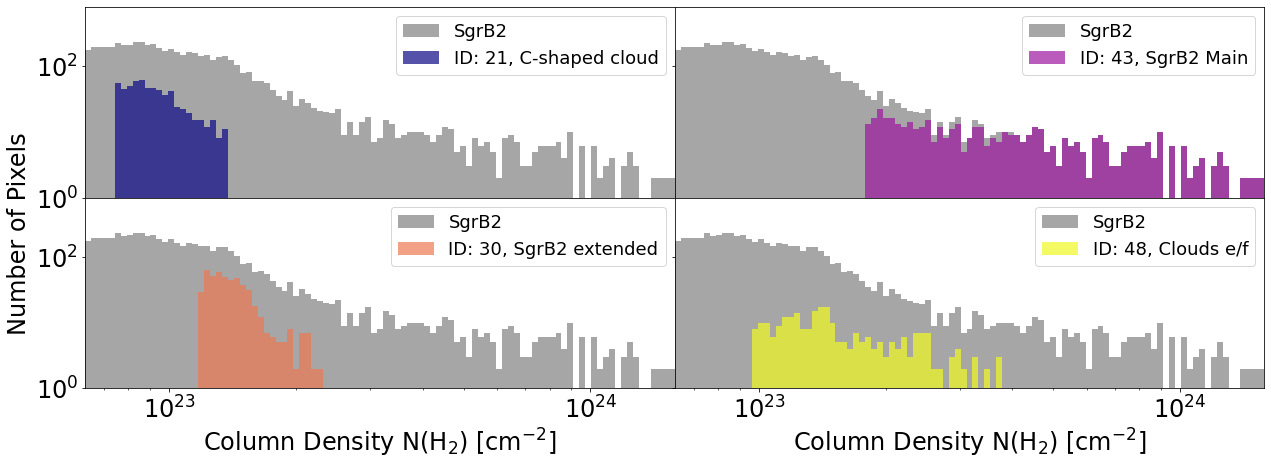

In [18]:
### NO LOG FIT!!! SAVED FOR POSTERITY?
# Plot joint figure with all PDFs, sample code from: 
# https://stackoverflow.com/questions/20174468/how-to-create-subplots-of-pictures-made-with-the-hist-function-in-matplotlib-p

### SgrB2 ###

fig,a = plt.subplots(2,2, sharex=True, sharey=True, figsize=(18, 7))
custom_xlim = (10**22.77815,10**24.2)
custom_ylim = (1,800)
plt.setp(a, xlim=custom_xlim, ylim=custom_ylim)
plt.style.use('default')
plt.rcParams.update({'font.size': 24}) #set fontsize

a = a.ravel()
i=1
for idx,ax in enumerate(a):
    bins = np.logspace(22.77815, 24.2,100)
    st = sts_sgrb2[idx]
    regnum = sgr['reg'+str(st)]
    reglabel = 'ID: '+str(st)+', '+names_sgrb2[idx]
    base= sgrb2
    baselabel= 'SgrB2'
    color= [rgb_sgrb2[idx]]
    ax.hist(base, bins, color='gray',alpha=0.7, log='True', label=baselabel)
    ax.set_xlabel('Column Density N(H$_2$) [cm$^{-2}$]')
    ax.hist(regnum, bins, color=color,alpha=0.7, log='True', label=reglabel)
    ax.set_xscale('log')
    ax.legend(loc='upper right', shadow=False, fontsize=18)
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
fig.text(0.01, 0.5, 'Number of Pixels', va='center', rotation='vertical')

plt.gcf().subplots_adjust(left=0.07) # make room for xy-axis

outfile = pathfigs+'sgrb2_pdfs_ALL.pdf'
plt.savefig(outfile, format='pdf', dpi=300)#, bbox_inches='tight')


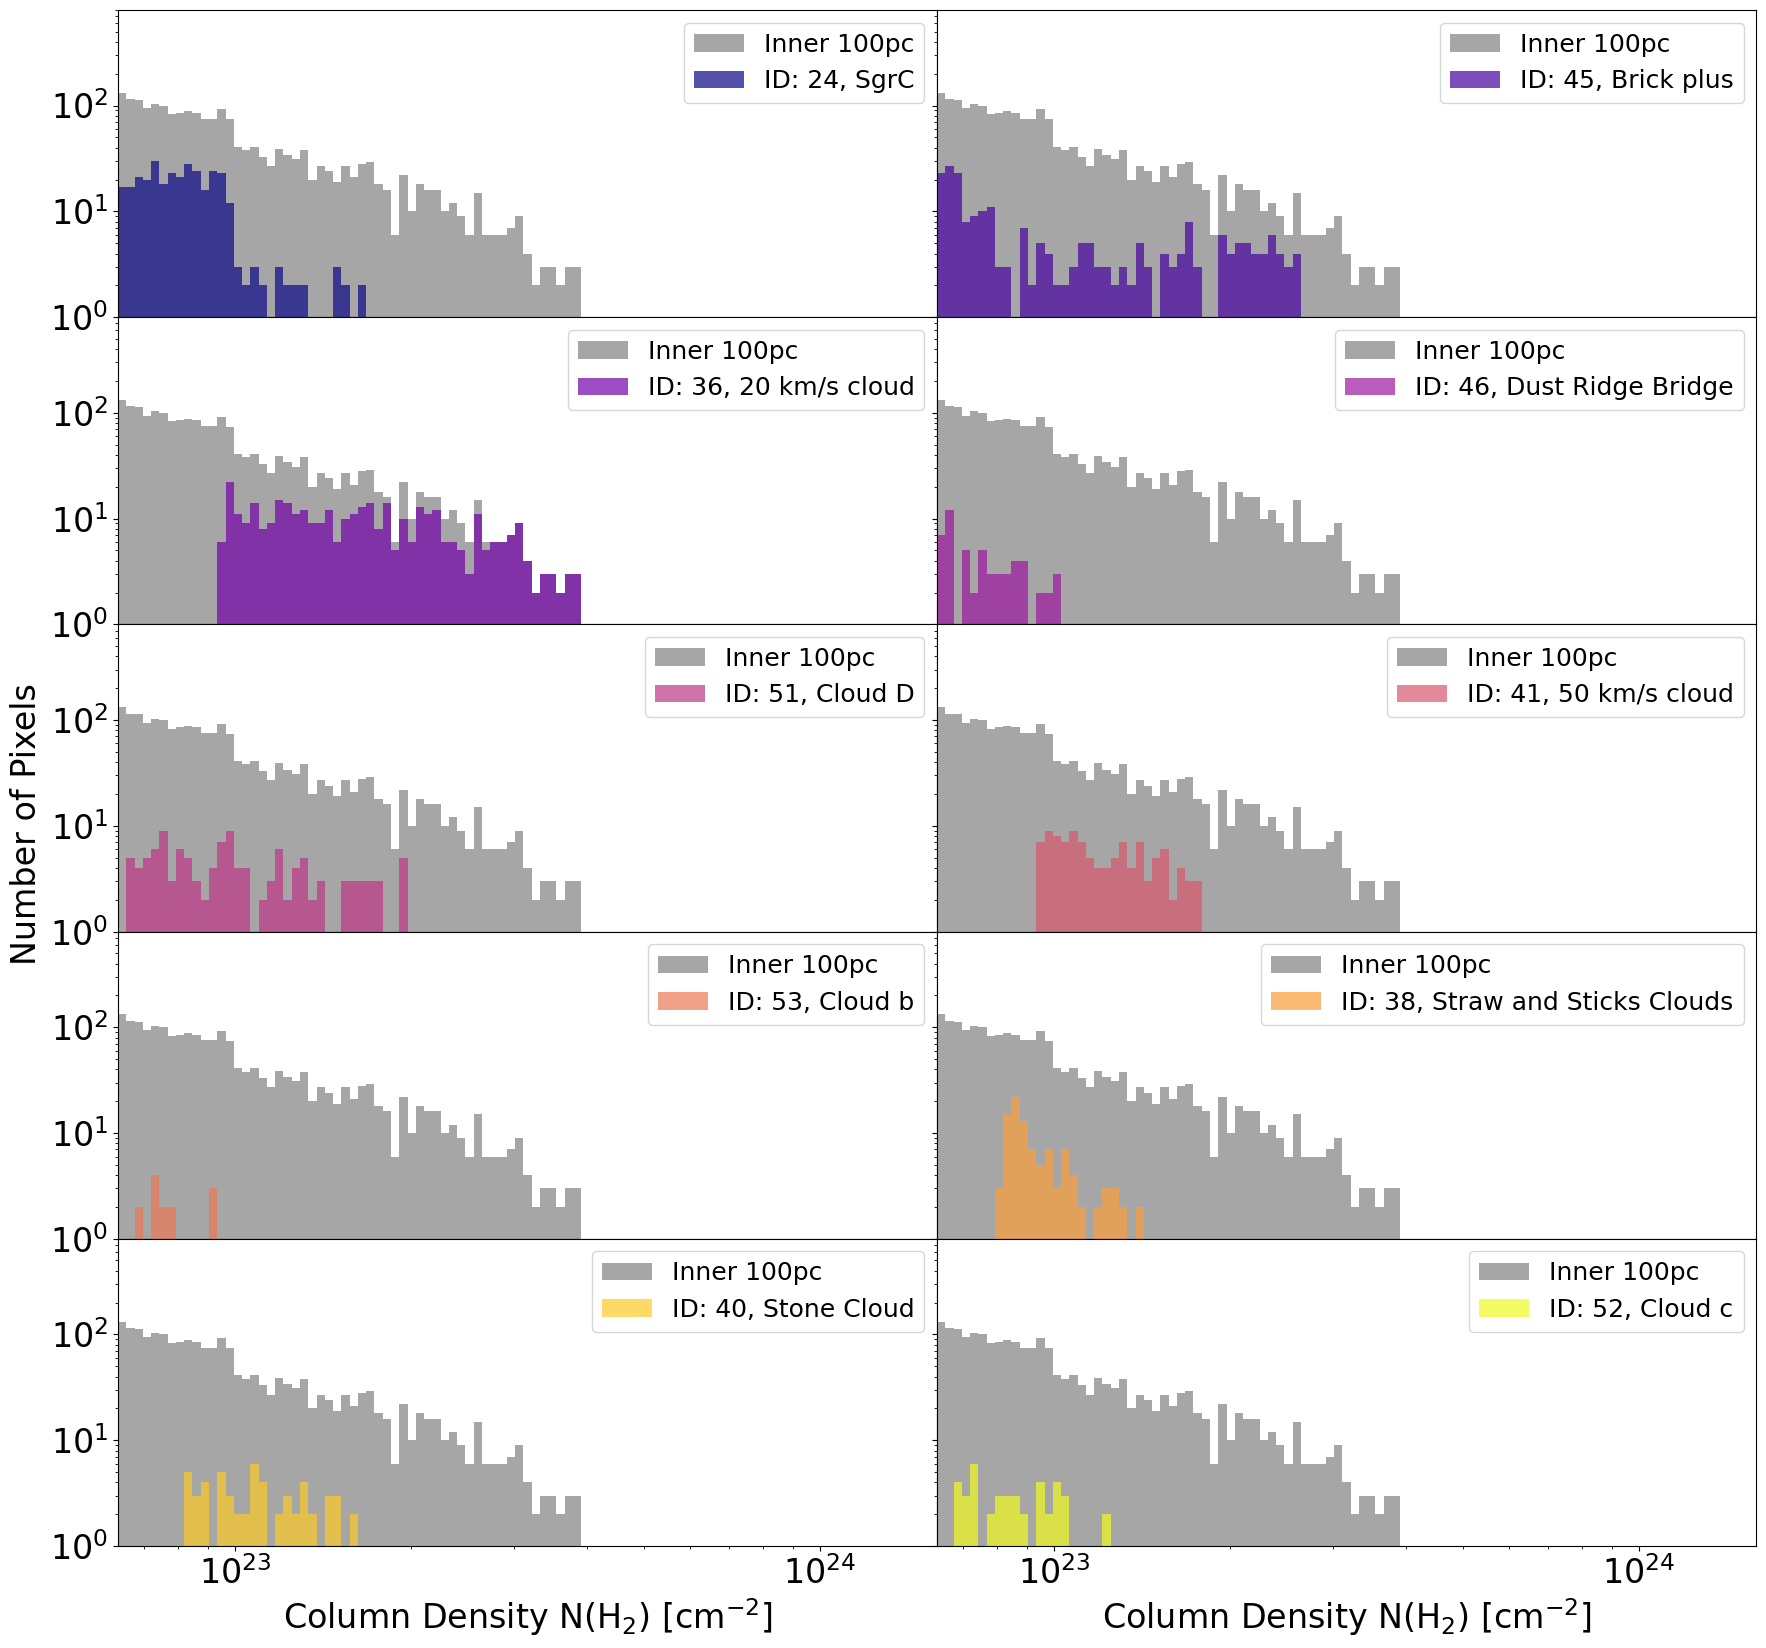

In [19]:
### NO LOG FIT!!! SAVED FOR POSTERITY?
# Plot joint figure with all PDFs, sample code from: 
# https://stackoverflow.com/questions/20174468/how-to-create-subplots-of-pictures-made-with-the-hist-function-in-matplotlib-p

### Inner 100pc ###

fig,a = plt.subplots(5,2, sharex=True, sharey=True, figsize=(18, 17))
custom_xlim = (10**22.77815,10**24.2)
custom_ylim = (1,800)
plt.setp(a, xlim=custom_xlim, ylim=custom_ylim)
plt.style.use('default')
plt.rcParams.update({'font.size': 24}) #set fon tsize


a = a.ravel()
for idx,ax in enumerate(a):
    bins = np.logspace(22.77815, 24.2,100)
    st = sts_inner[idx]
    regnum = inner['reg'+str(st)]
    reglabel = 'ID: '+str(st)+', '+names_inner100[idx]
    base= inner100
    baselabel= 'Inner 100pc'
    color= [rgb_inner[idx]]
    ax.hist(base, bins, color='gray',alpha=0.7, log='True', label=baselabel)
    ax.set_xlabel('Column Density N(H$_2$) [cm$^{-2}$]')
    ax.hist(regnum, bins, color=color,alpha=0.7, log='True', label=reglabel)
    ax.set_xscale('log')
    ax.legend(loc='upper right', shadow=False, fontsize=18)
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
fig.text(0.01, 0.5, 'Number of Pixels', va='center', rotation='vertical')

plt.gcf().subplots_adjust(left=0.07) # make room for xy-axis

outfile = pathfigs+'Inner100pc_pdfs_ALL.pdf'
plt.savefig(outfile, format='pdf', dpi=300)#, bbox_inches='tight')


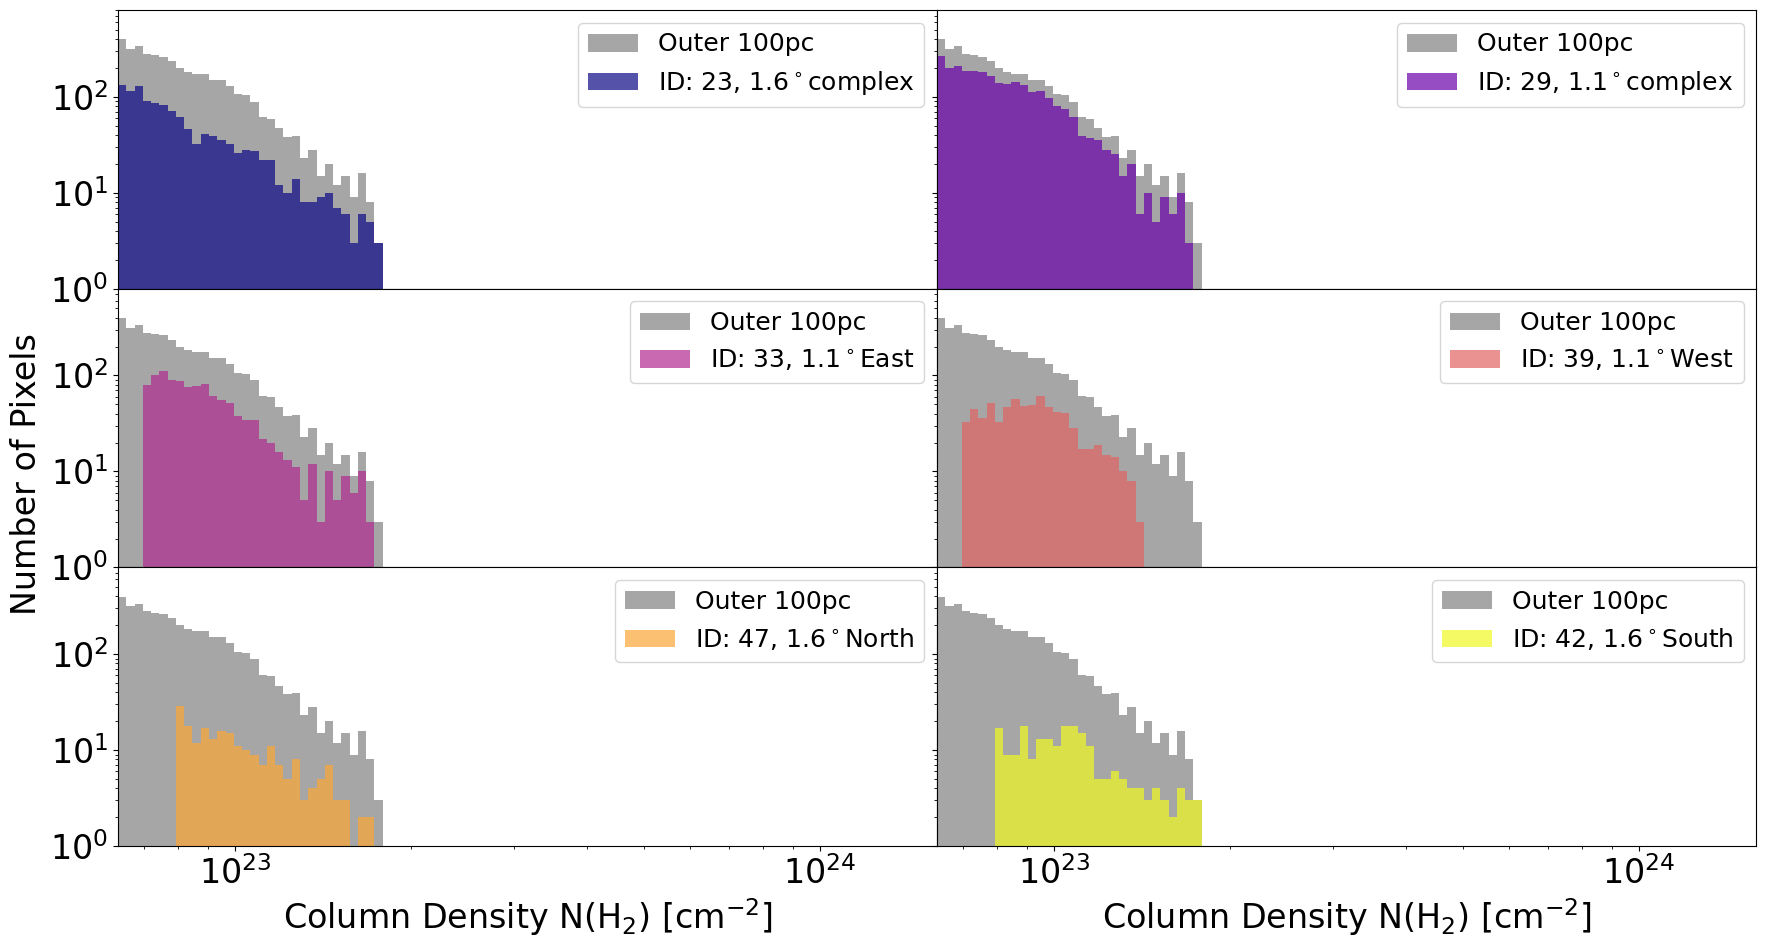

In [85]:
### NO LOG FIT!!! SAVED FOR POSTERITY?

# Plot joint figure with all PDFs, sample code from: 
# https://stackoverflow.com/questions/20174468/how-to-create-subplots-of-pictures-made-with-the-hist-function-in-matplotlib-p

### Outer 100pc ###

fig,a = plt.subplots(3,2, sharex=True, sharey=True, figsize=(18, 10))
custom_xlim = (10**22.77815,10**24.2)
custom_ylim = (1,800)
plt.setp(a, xlim=custom_xlim, ylim=custom_ylim)
plt.style.use('default')
plt.rcParams.update({'font.size': 24}) #set fon tsize


a = a.ravel()
for idx,ax in enumerate(a):
    bins = np.logspace(22.77815, 24.2,100)
    st = sts_outer[idx]
    regnum = outer['reg'+str(st)]
    reglabel = 'ID: '+str(st)+', '+names_outer100[idx]
    base= outer100
    baselabel= 'Outer 100pc'
    color= [rgb_outer[idx]]
    ax.hist(base, bins, color='gray',alpha=0.7, log='True', label=baselabel)
    ax.set_xlabel('Column Density N(H$_2$) [cm$^{-2}$]')
    ax.hist(regnum, bins, color=color,alpha=0.7, log='True', label=reglabel)
    ax.set_xscale('log')
    ax.legend(loc='upper right', shadow=False, fontsize=18)
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
fig.text(0.01, 0.5, 'Number of Pixels', va='center', rotation='vertical')

plt.gcf().subplots_adjust(left=0.07) # make room for xy-axis

outfile = pathfigs+'Outer100pc_pdfs_ALL.pdf'
plt.savefig(outfile, format='pdf', dpi=300)#, bbox_inches='tight')
